In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.patheffects as patheffects


# The file has .xlsx extension, so use read_excel instead of read_csv to avoid UnicodeDecodeError
df_wbdi = pd.read_csv('world_bank_development_indicators.csv')

df_income = pd.ExcelFile('income.xlsx')

# Display sheet names in the Excel file
print("Sheet names in the Excel file:", df_income.sheet_names)

df_income_economies = pd.read_excel(df_income, sheet_name='List of economies')
#df_income_composition = pd.read_excel(df_income, sheet_name='composition')
#df_income_notes = pd.read_excel(df_income, sheet_name='notes')


Sheet names in the Excel file: ['List of economies', 'composition', 'notes']


In [2]:
df_wbdi.shape

(17272, 50)

In [46]:
def format_example_values(series):
    vals = series.dropna().unique()[:5]
    
    formatted = []
    for v in vals:
        if isinstance(v, (int, float, np.number)):
            formatted.append(f"{v:.2f}")
        else:
            formatted.append(str(v))
    return ", ".join(formatted)

summary_df = pd.DataFrame({
    "Feature/variable": df_wbdi.columns,
    "Data type": df_wbdi.dtypes.values.astype(str),
    "Description": [""] * len(df_wbdi.columns),
    "Number of Unique values": [df_wbdi[col].nunique() for col in df_wbdi.columns],
    "Example values": [format_example_values(df_wbdi[col]) for col in df_wbdi.columns]
})

# Show all rows without truncation
with pd.option_context("display.max_rows", None, "display.max_colwidth", None):
    print(summary_df.to_markdown(index=False))



| Feature/variable                          | Data type   | Description   |   Number of Unique values | Example values                                                                                                                               |
|:------------------------------------------|:------------|:--------------|--------------------------:|:---------------------------------------------------------------------------------------------------------------------------------------------|
| country                                   | object      |               |                       203 | Afghanistan, Albania, Algeria, Angola, Antigua and Barbuda                                                                                   |
| date                                      | object      |               |                        62 | 1960-01-01, 1961-01-01, 1962-01-01, 1963-01-01, 1964-01-01                                                                                   |
| agricultur

In [51]:
# Select only numeric columns
num_df = df_wbdi.select_dtypes(include="number")

# Compute descriptive statistics
summary_table = num_df.describe().loc[
    ["count", "mean", "std", "min", "25%", "50%", "75%", "max"]
]

# Optional: round to 2 decimals
summary_table = summary_table.round(2)

summary_table = summary_table.T

print(summary_table.to_markdown())


|                                           |   count |             mean |              std |            min |              25% |              50% |              75% |             max |
|:------------------------------------------|--------:|-----------------:|-----------------:|---------------:|-----------------:|-----------------:|-----------------:|----------------:|
| agricultural_land%                        |   10872 |     36.86        |     22.43        |    0.26        |     17.77        |     37.65        |     54.71        |    93.44        |
| forest_land%                              |    6171 |     32.02        |     24.66        |    0           |     10.88        |     30.27        |     50.85        |    98.57        |
| land_area                                 |   11016 | 633316           |      1.70094e+06 |   10           |  14870           | 107400           | 472710           |     1.639e+07   |
| avg_precipitation                         |    9587 |   1197.78     

In [52]:
# Select categorical/object columns
cat_df = df_wbdi.select_dtypes(include=["object", "category"])

summary = pd.DataFrame(index=cat_df.columns)

# Count of non-missing values
summary["Count"] = cat_df.count()

# Number of unique values
summary["Number of unique values"] = cat_df.nunique()

# Most frequent value
summary["Most frequent value"] = cat_df.mode().iloc[0]

# Frequency of most frequent value
summary["Most frequent value (frequency)"] = [
    cat_df[col].value_counts().iloc[0] if cat_df[col].nunique() > 0 else 0
    for col in cat_df.columns
]

# Least frequent value
summary["Least frequent value"] = [
    cat_df[col].value_counts().idxmin() if cat_df[col].nunique() > 0 else None
    for col in cat_df.columns
]

# Frequency of least frequent value
summary["Least frequent value (frequency)"] = [
    cat_df[col].value_counts().iloc[-1] if cat_df[col].nunique() > 0 else 0
    for col in cat_df.columns
]

# Flip rows and columns
summary = summary.T

print(summary.to_markdown())


|                                  | country        | date       | Income_group   | Region                |
|:---------------------------------|:---------------|:-----------|:---------------|:----------------------|
| Count                            | 12337          | 12337      | 12337          | 12337                 |
| Number of unique values          | 203            | 62         | 4              | 7                     |
| Most frequent value              | Afghanistan    | 1995-01-01 | High income    | Europe & Central Asia |
| Most frequent value (frequency)  | 62             | 202        | 4679           | 3272                  |
| Least frequent value             | Cayman Islands | 1965-01-01 | Low income     | North America         |
| Least frequent value (frequency) | 1              | 195        | 1488           | 186                   |


In [6]:
# Add income/region information by merging the tables into a single dataframe.
df_wbdi = df_wbdi.merge(df_income_economies[['Economy', 'Income group', 'Region']], 
                       how='left', 
                       left_on='country', 
                       right_on='Economy').drop(columns=['Economy'])

In [4]:
# Cleaning: Clean up countries (some have weird names, e.g. post-demographic dividend)
df_wbdi['country'].unique()


# Drop rows that have a missing income group
df_wbdi = df_wbdi[~df_wbdi['Income group'].isna()]



In [5]:
# Impute or drop missing values
# Drop missing values where life expectancy is missing (as this is the variable I want to analyze)
print(df_wbdi['life_expectancy_at_birth'].isnull().sum())
df_wbdi = df_wbdi[~df_wbdi['life_expectancy_at_birth'].isna()]


1006


In [6]:
# Duplicates
print(df_wbdi.duplicated().sum())

# do not need to be dropped as there are none

0


In [7]:
# display the first, the last and a random sample of 7 entries
df_wbdi.head(1)
df_wbdi.tail(1)
df_wbdi.sample(7)

country        date  agricultural_land%  forest_land%  \
3184   Congo, Dem. Rep.  2008-01-01           11.336318     61.099226   
9682             Malawi  1982-01-01           42.745015           NaN   
12558              Peru  2011-01-01           19.503281     57.717770   
11178             Nepal  1975-01-01           28.034965           NaN   
7300          Indonesia  1999-01-01           25.324442     56.860348   
6283             Guinea  2006-01-01           57.504477     27.319713   
10987           Myanmar  1976-01-01           15.855189           NaN   

       land_area  avg_precipitation  trade_in_services%  \
3184   2267050.0             1543.0           14.795450   
9682     94280.0             1181.0            8.782432   
12558  1280000.0             1738.0            5.867268   
11178   143000.0             1500.0                 NaN   
7300   1811570.0             2702.0           12.124631   
6283    245720.0             1651.0            8.741192   
10987   653540.0             2091.0            4.194136   

       control_of_corruption_estimate  control_of_corruption_std  \
3184                        -1.261194                   0.206058   
9682                              NaN                        NaN   
12558                       -0.243968                   0.146024   
11178                             NaN                        NaN   
7300                              NaN                        NaN   
6283                        -1.121542                   0.185670   
10987                             NaN                        NaN   

       access_to_electricity%  ...  birth_rate  death_rate  \
3184                11.599179  ...      44.430      12.275   
9682                      NaN  ...      51.911      20.861   
12558               89.707491  ...      20.750       6.864   
11178                     NaN  ...      41.576      19.315   
7300                83.730000  ...      22.193       7.390   
6283                22.758894  ...      39.815      12.717   
10987                     NaN  ...      35.111      13.832   

       life_expectancy_at_birth   population  rural_population  \
3184                     55.339   62249724.0        37987272.0   
9682                     45.991    6784347.0         6141123.0   
12558                    74.133   29477721.0         6892776.0   
11178                    45.040   13925541.0        13252937.0   
7300                     66.221  210996910.0       124927050.0   
6283                     55.108    9330625.0         6294533.0   
10987                    52.982   30941375.0        23536176.0   

       voice_and_accountability_estimate  voice_and_accountability_std  \
3184                           -1.387891                      0.127771   
9682                                 NaN                           NaN   
12558                           0.131240                      0.111646   
11178                                NaN                           NaN   
7300                                 NaN                           NaN   
6283                           -1.227811                      0.135431   
10987                                NaN                           NaN   

       intentional_homicides         Income group                     Region  
3184                     NaN           Low income         Sub-Saharan Africa  
9682                     NaN           Low income         Sub-Saharan Africa  
12558               5.485499  Upper middle income  Latin America & Caribbean  
11178                    NaN  Lower middle income                 South Asia  
7300                0.990536  Upper middle income        East Asia & Pacific  
6283                     NaN  Lower middle income         Sub-Saharan Africa  
10987                    NaN  Lower middle income        East Asia & Pacific  

[7 rows x 52 columns]

In [8]:
# Get data type of relevant columns (live expectancy and income)
# @group add data types of relevant columns in your analysis here
df_wbdi[['life_expectancy_at_birth', 'Region']].dtypes


life_expectancy_at_birth    float64
Region                       object
dtype: object

In [31]:
# basic summary statistics for both categorical and numerical variables
df_wbdi.describe()
df_wbdi.dtypes

country                                       object
date                                          object
agricultural_land%                           float64
forest_land%                                 float64
land_area                                    float64
avg_precipitation                            float64
trade_in_services%                           float64
control_of_corruption_estimate               float64
control_of_corruption_std                    float64
access_to_electricity%                       float64
renewvable_energy_consumption%               float64
electric_power_consumption                   float64
CO2_emisions                                 float64
other_greenhouse_emisions                    float64
population_density                           float64
inflation_annual%                            float64
real_interest_rate                           float64
risk_premium_on_lending                      float64
research_and_development_expenditure%        f

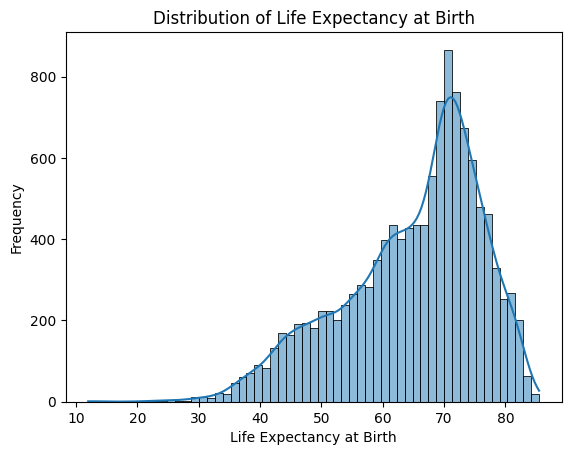

In [32]:
# basic plots for categorical and numerical variables to check distributions and counts
# @group add plotting of relevant columns in your analysis below

# life expectancy distribution
sns.histplot(data=df_wbdi, x='life_expectancy_at_birth', kde=True)
plt.title('Distribution of Life Expectancy at Birth')
plt.xlabel('Life Expectancy at Birth')
plt.ylabel('Frequency')
plt.show()


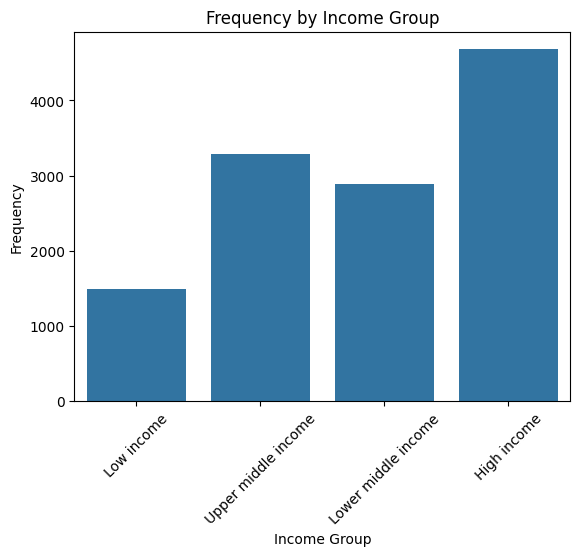

In [33]:
# Counts of income groups
sns.countplot(data=df_wbdi, x='Income group')
plt.title('Frequency by Income Group')
plt.xlabel('Income Group')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

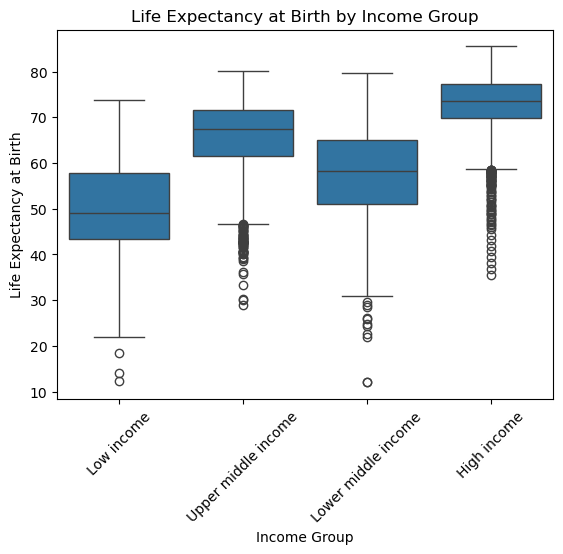

In [ ]:
# Anova test to see if there are significant differences in life expectancy across different income groups
# Plot data with box plot
# Null hypothesis H0: the means of life expectancy at birth are not significantly different between income groups
# and differences could be just by chance
# Alternative hypothesis H1: At least one mean of life expectancy of the different income groups is significantly different from the others 
order = df_wbdi.groupby('Income_group')['life_expectancy_at_birth'].mean().sort_values().index


sns.boxplot(data=df_wbdi, x='Income group', y='life_expectancy_at_birth', order=order)
plt.title('Life Expectancy at Birth by Income Group')
plt.xlabel('Income Group')
plt.ylabel('Life Expectancy at Birth')
plt.xticks(rotation=45)
plt.show()

In [35]:
# Check assumptions for ANOVA
# 1. Independent samples
# cannot be tested with the data, but we assume it is met based on study design

# Equal sample sizes of groups
group_sizes = df_wbdi['Income group'].value_counts()
print("Group sizes:\n", group_sizes)

# not equal, but we will proceed with ANOVA as it is robust to some inequality in group sizes

Group sizes:
 High income            4679
Upper middle income    3286
Lower middle income    2884
Low income             1488
Name: Income group, dtype: int64


In [36]:
# Equal variances of groups
# we can look at the boxplots above
# The length of the boxplots, and therefore the variances, differ
# but one can argue that they are still similar enough to meet the assumption

In [37]:
# Normal distribution of the dependent variable
# see histogram above
# it is not perfectly normal, but at least approximately
# with larger sample sizes ANOVA is robust to moderate deviations from normality

In [38]:
# Rename income group to Income_group for easier access in formula
df_wbdi = df_wbdi.rename(columns={'Income group': 'Income_group'})

In [39]:
# Run an ANOVA
formula = 'life_expectancy_at_birth ~ C(Income_group)'
model = ols(formula, data=df_wbdi).fit()
anova_table = anova_lm(model, typ=2)
print(anova_table)

# we reject the null hypothesis as the p-value is less than 0.05
# There are significant differences in life expectancy at birth between different income groups.

                        sum_sq       df            F  PR(>F)
C(Income_group)  790690.028043      3.0  4196.991473     0.0
Residual         774489.709111  12333.0          NaN     NaN


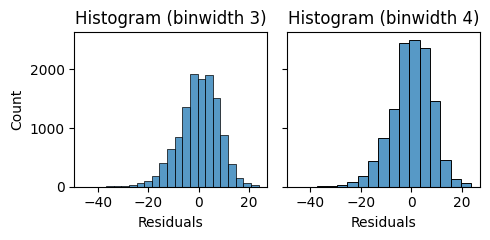

In [40]:
# Inspect the residuals
# Extract the residuals from the model
res = model.resid

# Set up 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(5, 2.5), sharey=True)

# Plot the residuals with bin width of 3
sns.histplot(res, binwidth=3, ax=axes[0])
axes[0].set_title('Histogram (binwidth 3)')
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Count')

# Plot the residuals with bin width of 4
sns.histplot(res, binwidth=4, ax=axes[1])
axes[1].set_title('Histogram (binwidth 4)')
axes[1].set_xlabel('Residuals')

# Adjust layout
plt.tight_layout()
plt.show()

# The residuals appear to be approximately normally distributed, 
# which supports the validity of the ANOVA results.

In [41]:
# Interpretation of results
# Extract the sum of squares values for the model and residuals
SS_model = anova_table['sum_sq'].iloc[:-1].sum()  
SS_residual = anova_table['sum_sq'].iloc[-1]  

# Total sum of squares
SS_total = SS_model + SS_residual

# Explained variance
explained_variance = SS_model / SS_total
print(f'Explained Variance: {explained_variance:.3f}')

# The sum of squares shows us how much variation is explained by the income group factor.
# It shows that approximately 50,5% of the variance in life expectancy at birth c
# an be explained by differences in income groups.

Explained Variance: 0.505


In [42]:
# Run a post-hoc test (Tukey's HSD) to determine which specific groups differ
# Run Tukey HSD test
tukey = pairwise_tukeyhsd(endog=df_wbdi['life_expectancy_at_birth'], groups=df_wbdi['Income_group'], alpha=0.05)
print(tukey)

# From the results, we can see which specific income groups have significantly different life expectancies at birth.
# The results indicate that all income groups differ significantly from each other 
# in terms of life expectancy at birth.

              Multiple Comparison of Means - Tukey HSD, FWER=0.05              
       group1              group2       meandiff p-adj  lower    upper   reject
-------------------------------------------------------------------------------
        High income          Low income   -22.96   0.0  -23.566  -22.354   True
        High income Lower middle income -15.3906   0.0 -15.8726 -14.9086   True
        High income Upper middle income   -7.259   0.0  -7.7225  -6.7956   True
         Low income Lower middle income   7.5694   0.0   6.9195   8.2193   True
         Low income Upper middle income   15.701   0.0  15.0648  16.3372   True
Lower middle income Upper middle income   8.1316   0.0    7.612   8.6511   True
-------------------------------------------------------------------------------


In [47]:
df_wbdi.isnull().sum()/df_wbdi.shape[0]*100

country                                       0.000000
date                                          0.000000
agricultural_land%                           11.874848
forest_land%                                 49.979736
land_area                                    10.707627
avg_precipitation                            22.290670
trade_in_services%                           45.943098
control_of_corruption_estimate               65.121180
control_of_corruption_std                    65.121180
access_to_electricity%                       53.992056
renewvable_energy_consumption%               50.174273
electric_power_consumption                   54.381130
CO2_emisions                                 54.275756
other_greenhouse_emisions                    54.275756
population_density                           10.707627
inflation_annual%                            34.400584
real_interest_rate                           66.174921
risk_premium_on_lending                      81.510902
research_a

In [49]:
df_wbdi.shape[0]

12337

In [52]:
df_wbdi["country"].value_counts()

country
Afghanistan           62
Montenegro            62
Mozambique            62
Myanmar               62
Namibia               62
                      ..
Faroe Islands         38
West Bank and Gaza    32
Liechtenstein         28
Palau                  4
Cayman Islands         1
Name: count, Length: 203, dtype: int64

In [54]:
df_wbdi.columns

Index(['country', 'date', 'agricultural_land%', 'forest_land%', 'land_area',
       'avg_precipitation', 'trade_in_services%',
       'control_of_corruption_estimate', 'control_of_corruption_std',
       'access_to_electricity%', 'renewvable_energy_consumption%',
       'electric_power_consumption', 'CO2_emisions',
       'other_greenhouse_emisions', 'population_density', 'inflation_annual%',
       'real_interest_rate', 'risk_premium_on_lending',
       'research_and_development_expenditure%', 'central_goverment_debt%',
       'tax_revenue%', 'expense%', 'goverment_effectiveness_estimate',
       'goverment_effectiveness_std', 'human_capital_index', 'doing_business',
       'time_to_get_operation_license', 'statistical_performance_indicators',
       'individuals_using_internet%', 'logistic_performance_index',
       'military_expenditure%', 'GDP_current_US',
       'political_stability_estimate', 'political_stability_std',
       'rule_of_law_estimate', 'rule_of_law_std',
       'reg

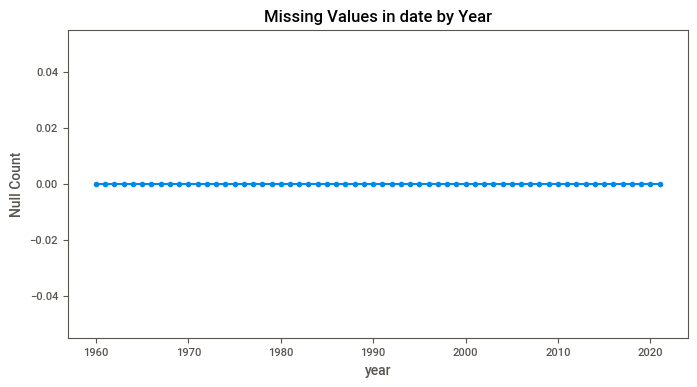

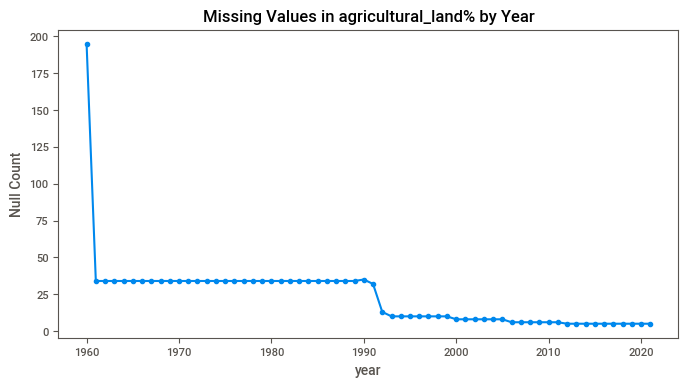

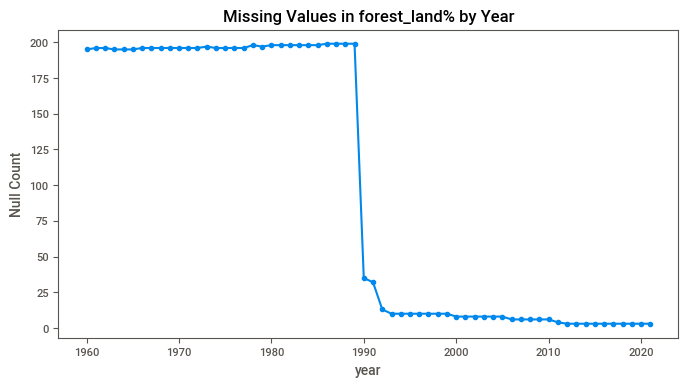

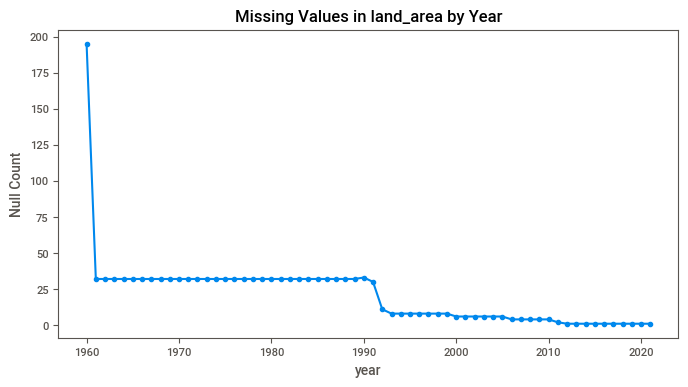

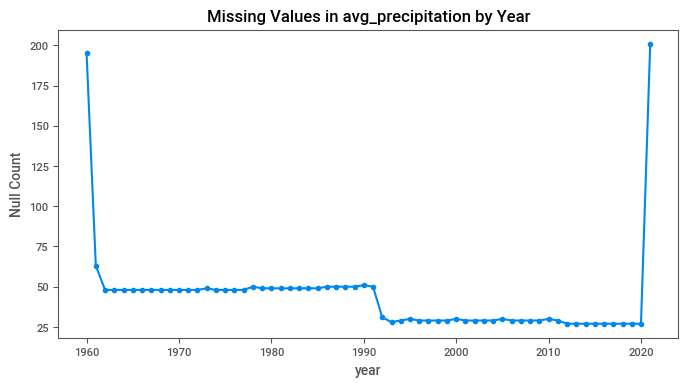

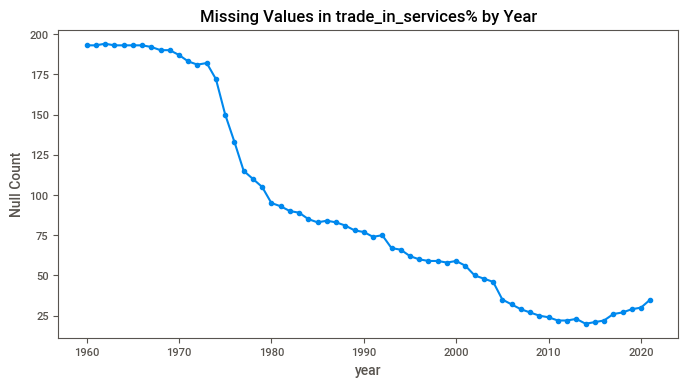

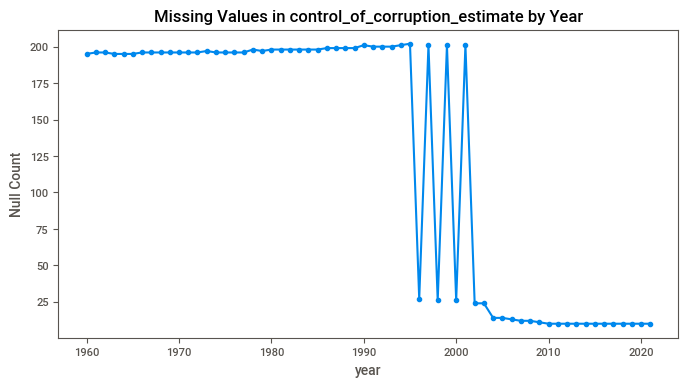

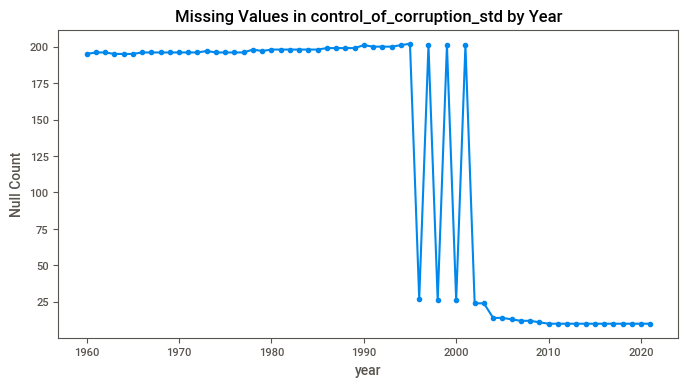

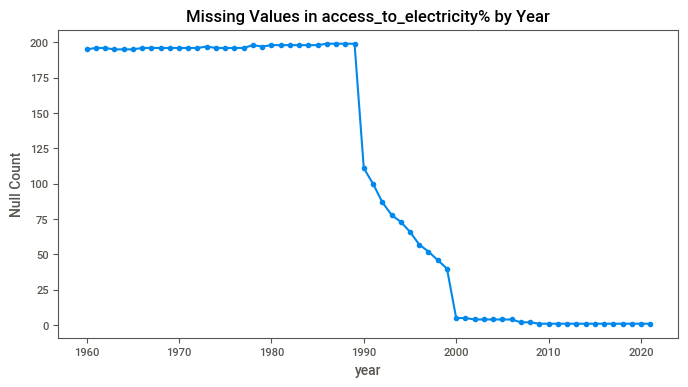

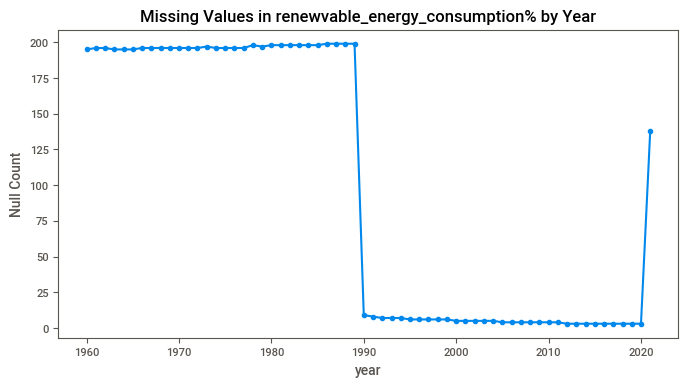

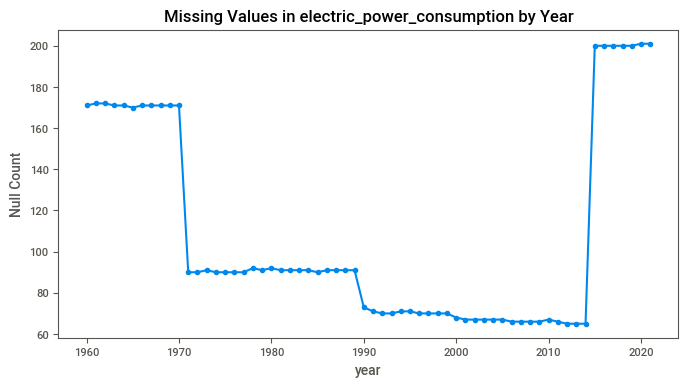

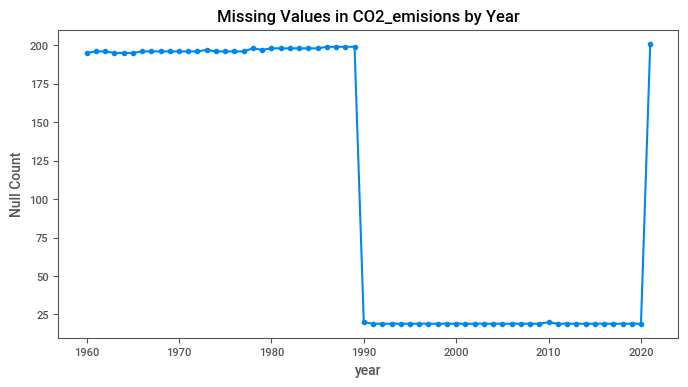

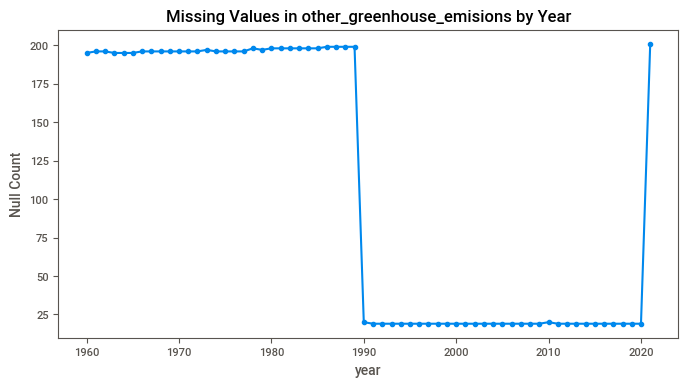

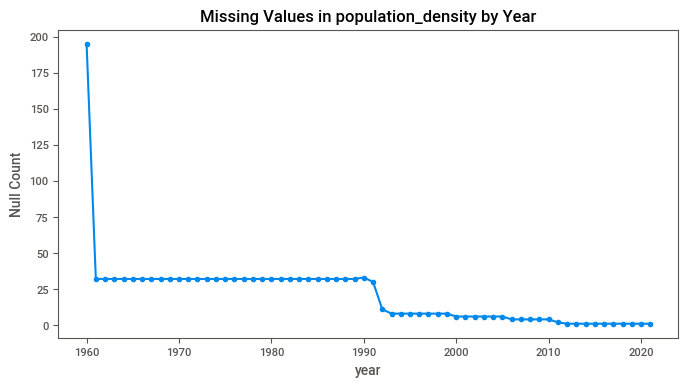

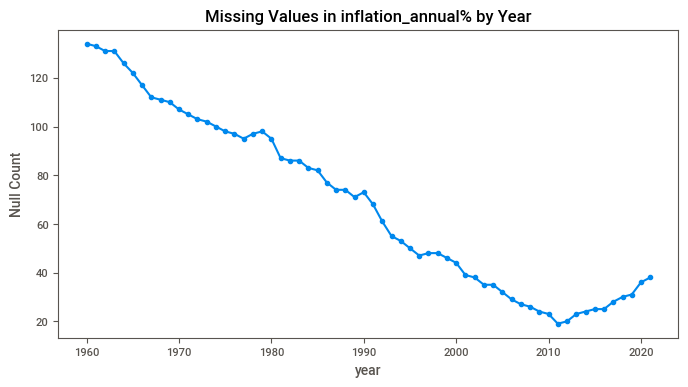

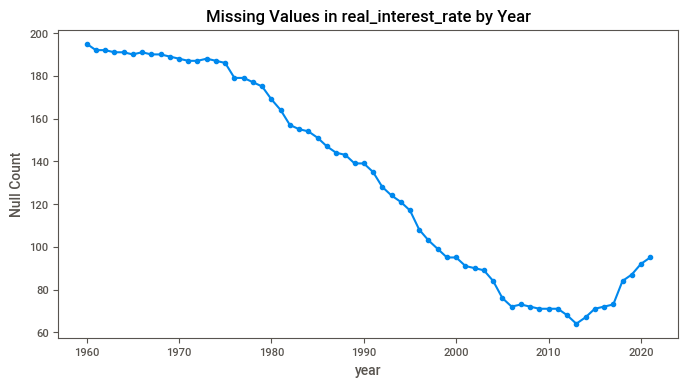

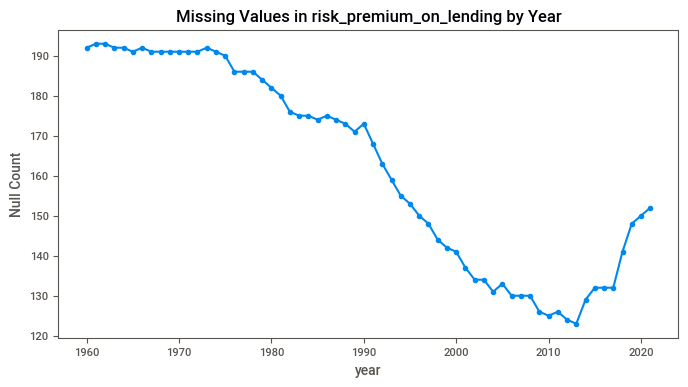

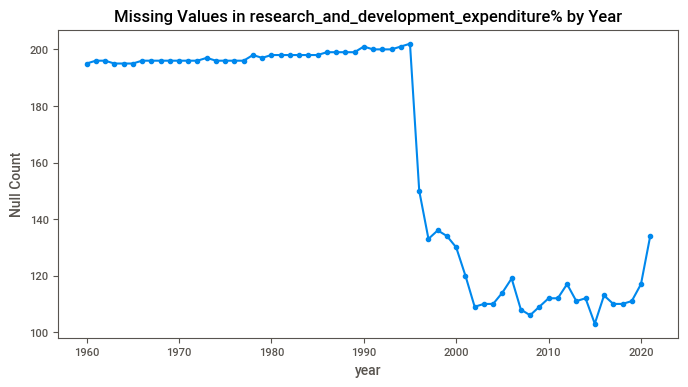

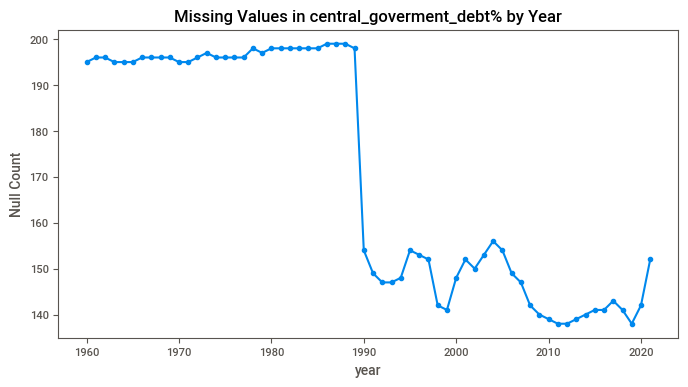

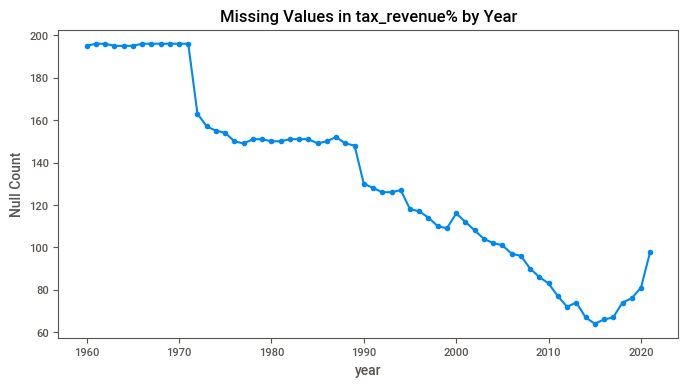

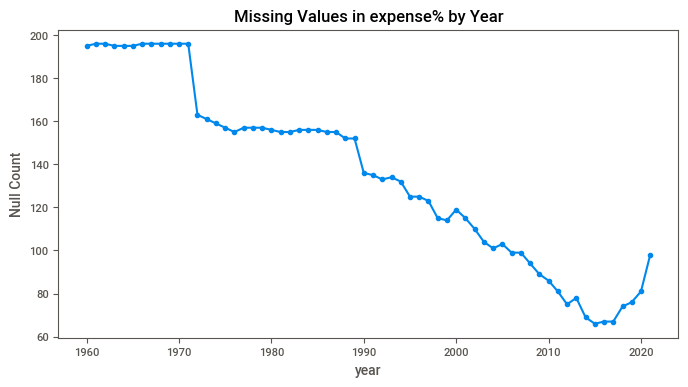

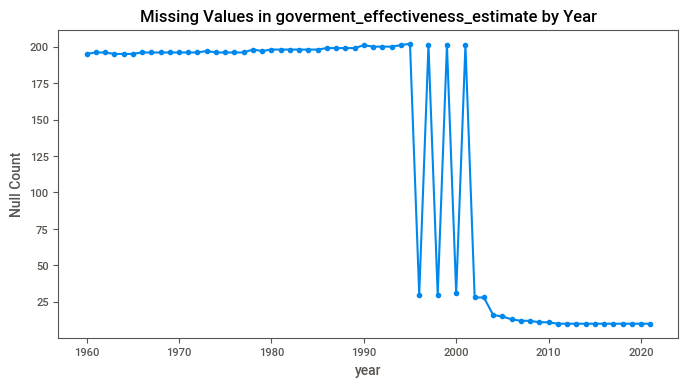

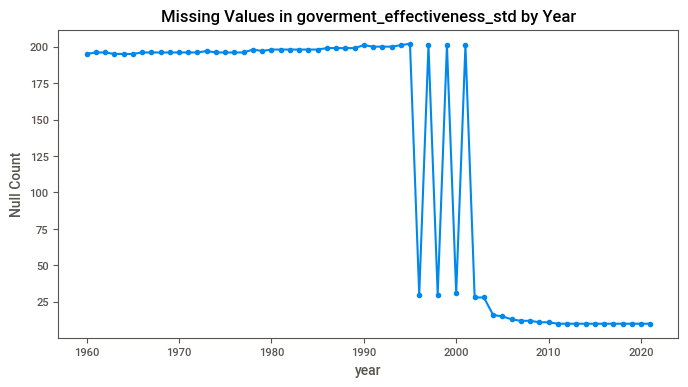

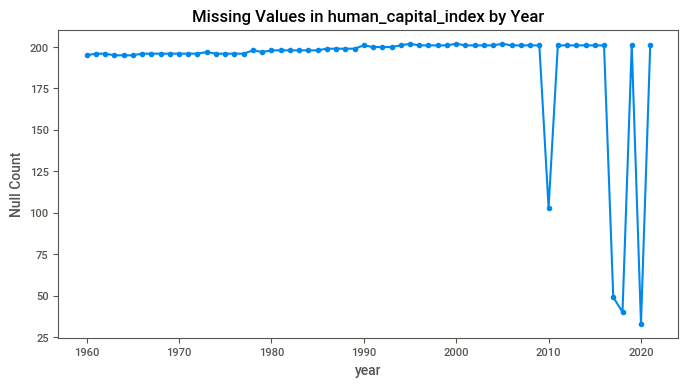

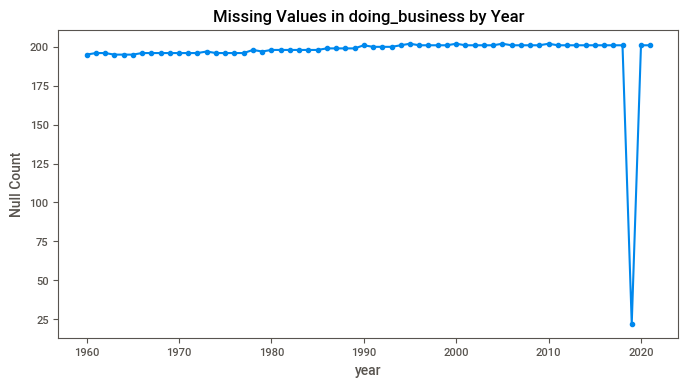

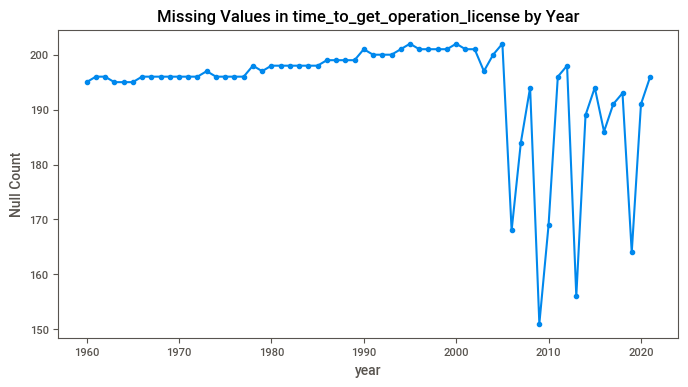

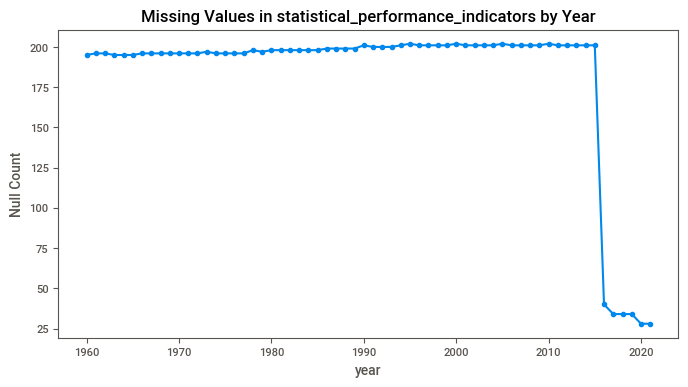

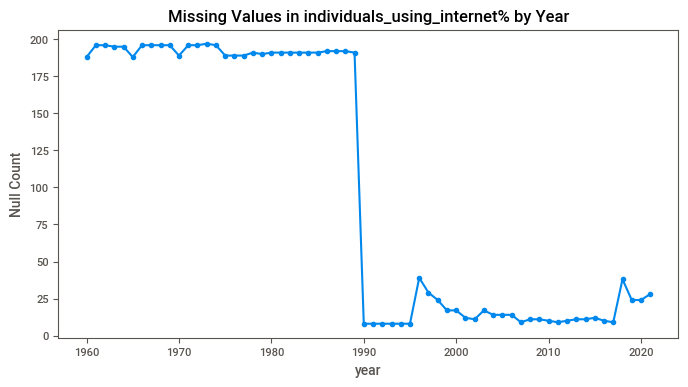

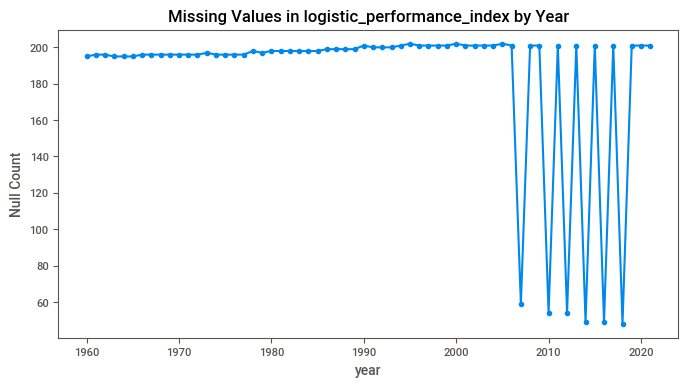

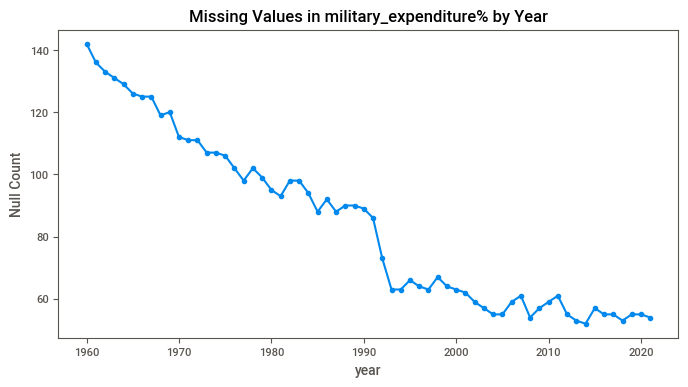

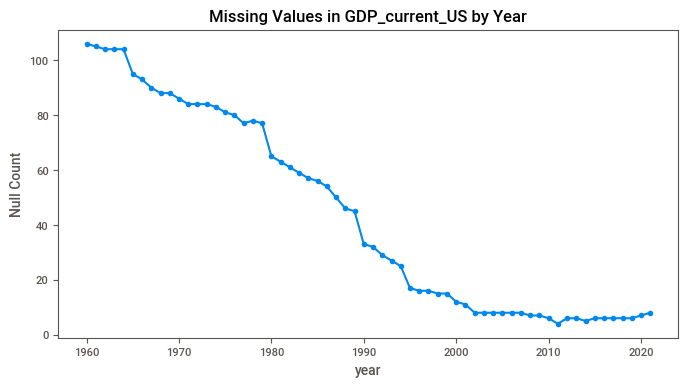

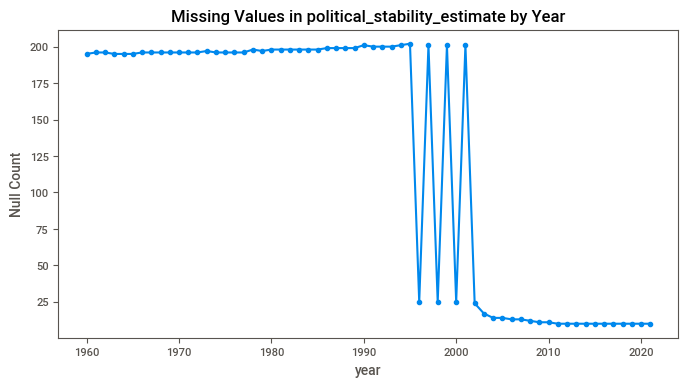

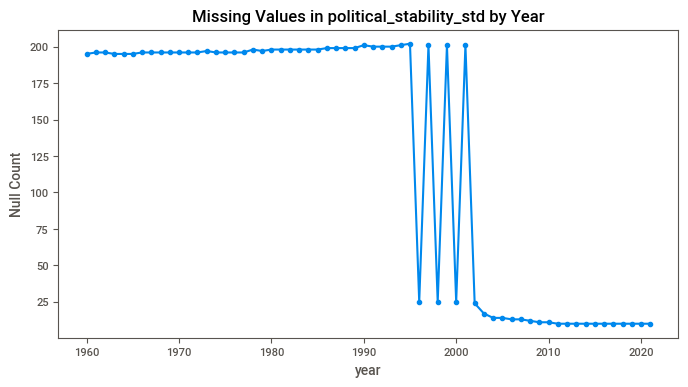

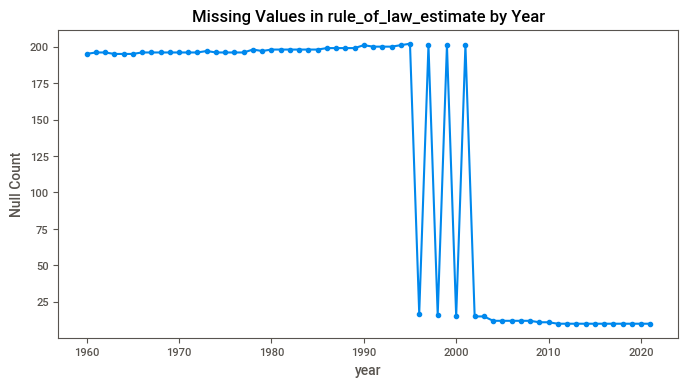

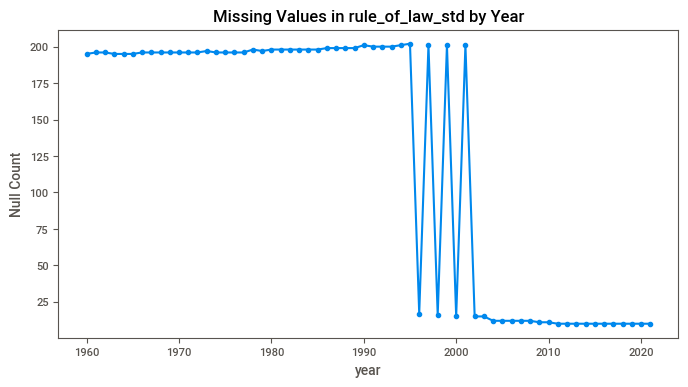

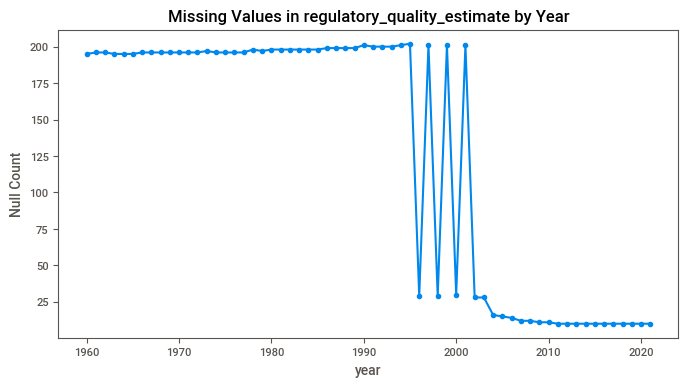

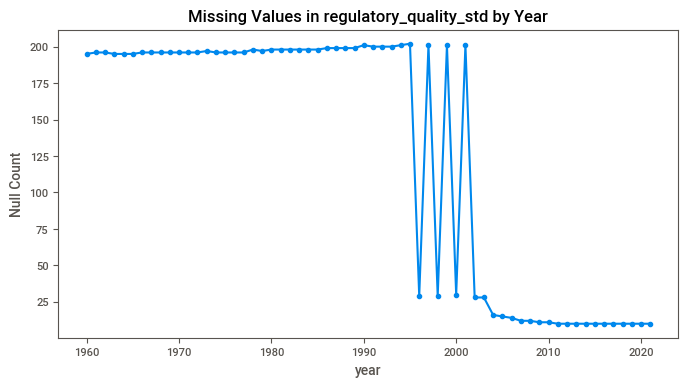

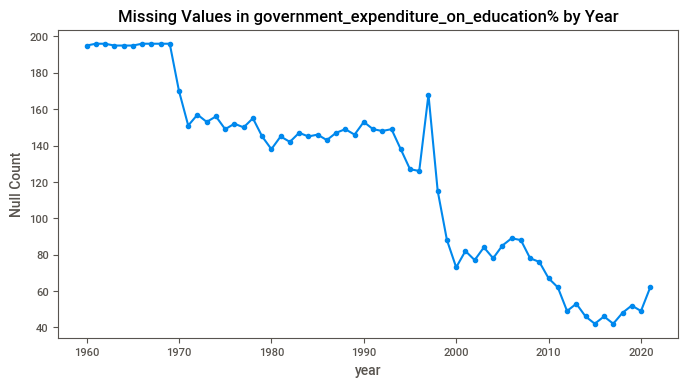

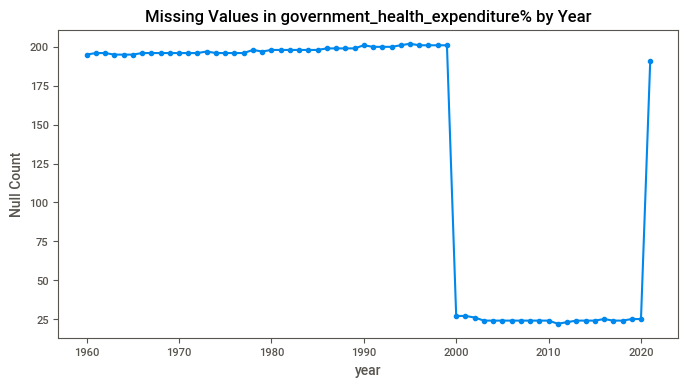

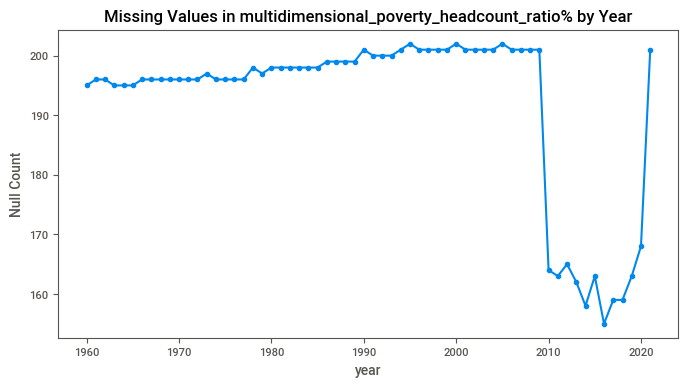

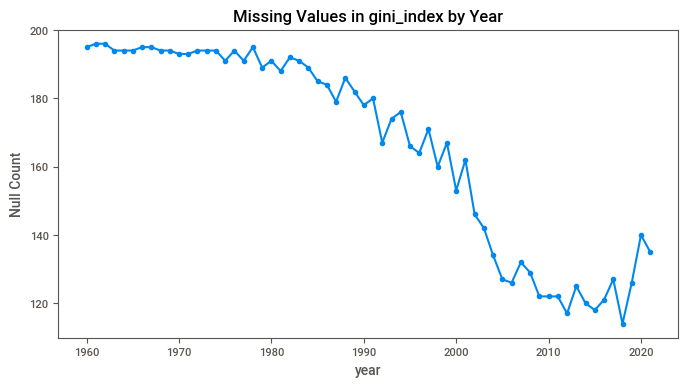

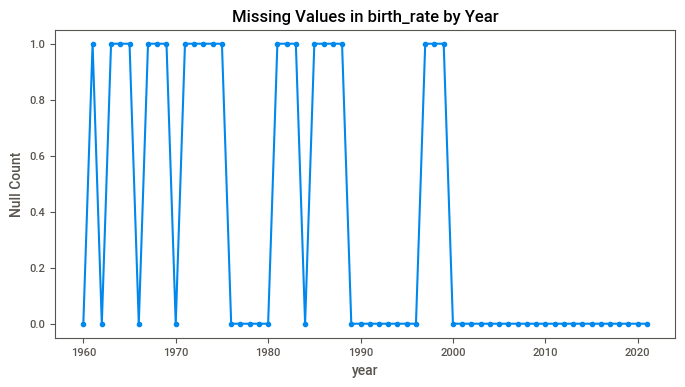

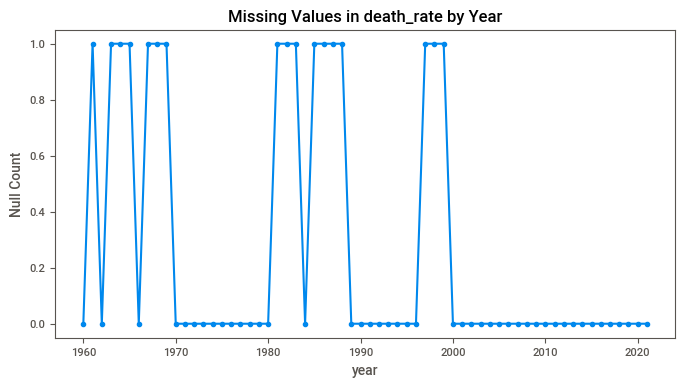

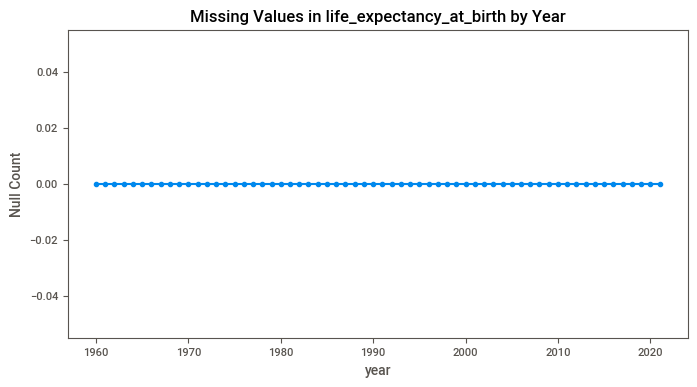

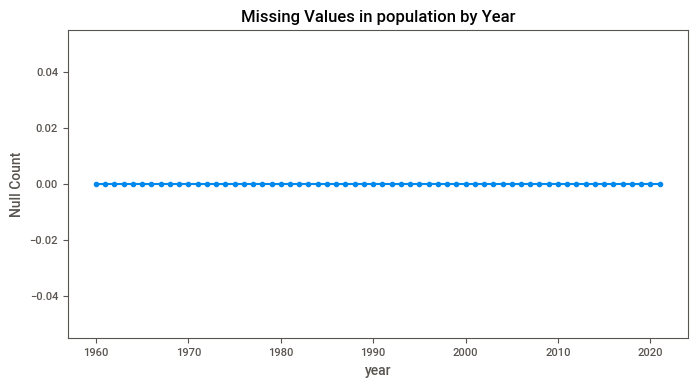

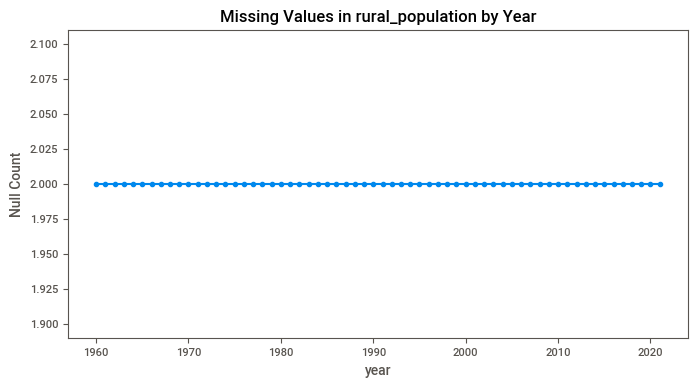

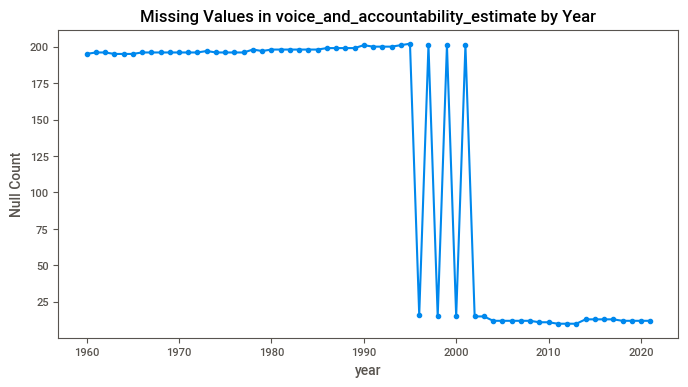

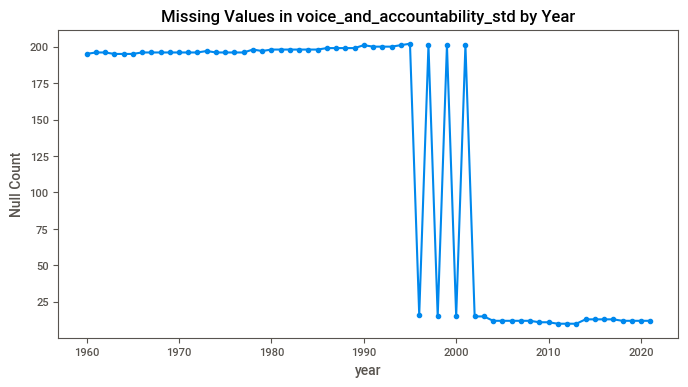

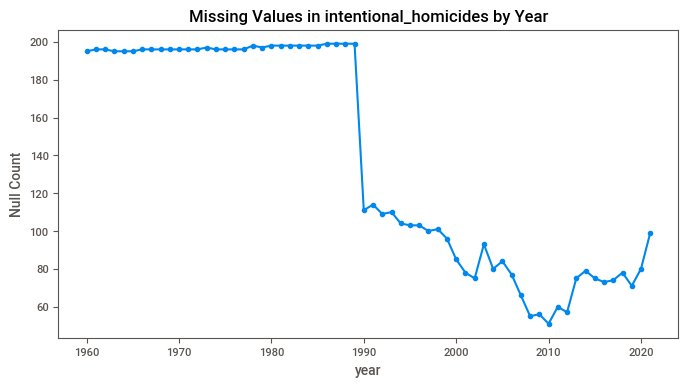

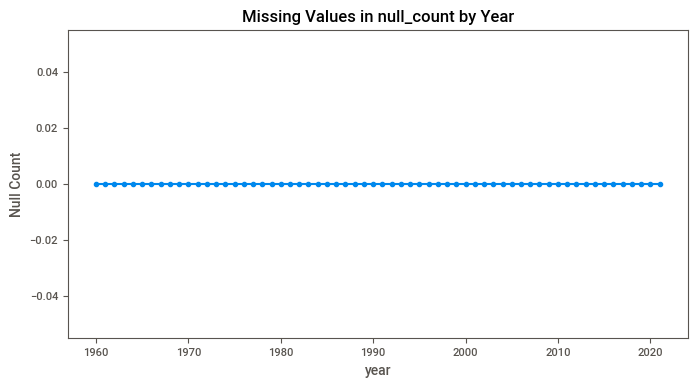

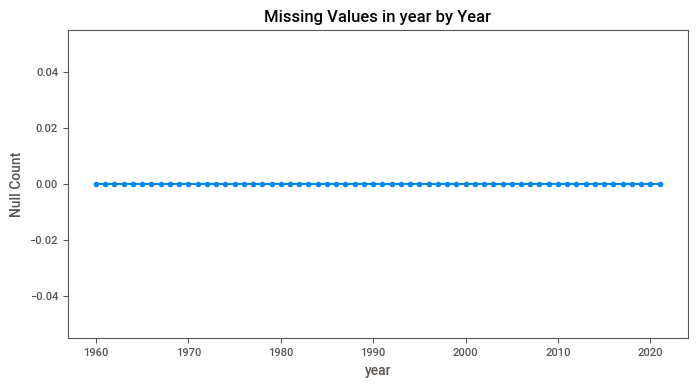

In [41]:
for col in num_cols:
    dataset.groupby("year")[col].apply(lambda x: x.isna().sum()).plot(
        kind="line", figsize=(8,4), marker="o", title=f"Missing Values in {col} by Year"
    )
    plt.ylabel("Null Count")
    plt.show()


In [13]:
dataset = df_wbdi.copy()

In [27]:
dataset.groupby("country")["null_count"].sum().values


array([1769, 1539, 1591, 1625, 1705, 1544, 1712, 1969, 1349, 1393, 1738,
       1535, 1533, 1516, 1613, 1695, 1593, 1551, 1641, 1997, 1634, 1483,
       1835, 1508, 1508, 2342, 1659, 1486, 1598, 1577, 1694, 1698, 1568,
       1263,   21, 1731, 1746, 2399, 1426, 1552, 1425, 1810, 1658, 1649,
       1442, 1701, 1760, 1457, 1670, 1404, 1790, 1686, 1413, 1528, 1422,
       1484, 1792, 2003, 1719, 1563, 1343, 1554, 1387, 1357, 2283, 1653,
       1621, 1709, 1411, 1541, 2380, 1390, 1407, 1706, 2115, 1461, 1758,
       1754, 1610, 1635, 1480, 1775, 1430, 1406, 1394, 1442, 1513, 1656,
       1403, 2355, 1352, 1323, 1394, 1417, 1478, 1758, 1481, 1882, 1942,
       1402, 2370, 1522, 1729, 1726, 1748, 1608, 1521, 1788, 1715,  623,
       1714, 1540, 1911, 1529, 1585, 1378, 1641, 1636, 1415, 2029, 1675,
       1413, 1391, 1981, 1675, 1582, 2052, 1491, 1663, 1536, 1601, 2024,
       1538, 1364, 2278, 1442, 1580, 1639, 1547, 1781, 1381, 1611, 1483,
        125, 1525, 1578, 1497, 1435, 1413, 1537, 14

In [29]:
dataset["date"] = pd.to_datetime(dataset["date"])
dataset["year"] = dataset["date"].dt.year


In [30]:
dataset["year"]

0        1960
1        1961
2        1962
3        1963
4        1964
         ... 
17265    2017
17266    2018
17267    2019
17268    2020
17269    2021
Name: year, Length: 12337, dtype: int32

In [32]:
(dataset.isnull().any(axis=1)
   .groupby(dataset["year"])
   .sum()
   .sort_values(ascending=True))


year
1960    195
1963    195
1964    195
1965    195
1977    196
       ... 
2021    201
2010    202
2000    202
1995    202
2005    202
Length: 62, dtype: int64

In [46]:
dataset2 = dataset[dataset["year"] > 1992]


In [50]:
dataset2.isnull().sum()/dataset2.shape[0]*100

country                                       0.000000
date                                          0.000000
agricultural_land%                            3.497942
forest_land%                                  3.120713
land_area                                     2.126200
avg_precipitation                            17.112483
trade_in_services%                           19.530178
control_of_corruption_estimate               26.217421
control_of_corruption_std                    26.217421
access_to_electricity%                        7.870370
renewvable_energy_consumption%                4.492455
electric_power_consumption                   49.537037
CO2_emisions                                 12.585734
other_greenhouse_emisions                    12.585734
population_density                            2.126200
inflation_annual%                            17.112483
real_interest_rate                           42.781207
risk_premium_on_lending                      68.432785
research_a

In [51]:
dataset2[["country", "Region"]]

,country,Region
33,Afghanistan,"Middle East, North Africa, Afghanistan & Pakistan"
34,Afghanistan,"Middle East, North Africa, Afghanistan & Pakistan"
35,Afghanistan,"Middle East, North Africa, Afghanistan & Pakistan"
36,Afghanistan,"Middle East, North Africa, Afghanistan & Pakistan"
37,Afghanistan,"Middle East, North Africa, Afghanistan & Pakistan"
...,...,...
17265,Zimbabwe,Sub-Saharan Africa
17266,Zimbabwe,Sub-Saharan Africa
17267,Zimbabwe,Sub-Saharan Africa
17268,Zimbabwe,Sub-Saharan Africa


In [52]:
dataset2.groupby(["country"])["Region"].count()

country
Afghanistan              29
Albania                  29
Algeria                  29
Angola                   29
Antigua and Barbuda      29
                         ..
Virgin Islands (U.S.)    29
West Bank and Gaza       29
Yemen, Rep.              29
Zambia                   29
Zimbabwe                 29
Name: Region, Length: 203, dtype: int64

In [54]:
dataset2["country"].value_counts()

country
Afghanistan        29
North Macedonia    29
Myanmar            29
Namibia            29
Nauru              29
                   ..
Greenland          29
Zimbabwe           29
Liechtenstein      28
Palau               3
Cayman Islands      1
Name: count, Length: 203, dtype: int64

In [57]:
pd.set_option('display.max_columns', None)


In [59]:
dataset.columns

Index(['country', 'date', 'agricultural_land%', 'forest_land%', 'land_area',
       'avg_precipitation', 'trade_in_services%',
       'control_of_corruption_estimate', 'control_of_corruption_std',
       'access_to_electricity%', 'renewvable_energy_consumption%',
       'electric_power_consumption', 'CO2_emisions',
       'other_greenhouse_emisions', 'population_density', 'inflation_annual%',
       'real_interest_rate', 'risk_premium_on_lending',
       'research_and_development_expenditure%', 'central_goverment_debt%',
       'tax_revenue%', 'expense%', 'goverment_effectiveness_estimate',
       'goverment_effectiveness_std', 'human_capital_index', 'doing_business',
       'time_to_get_operation_license', 'statistical_performance_indicators',
       'individuals_using_internet%', 'logistic_performance_index',
       'military_expenditure%', 'GDP_current_US',
       'political_stability_estimate', 'political_stability_std',
       'rule_of_law_estimate', 'rule_of_law_std',
       'reg

In [58]:
dataset[[""]]

,country,date,agricultural_land%,forest_land%,land_area,avg_precipitation,trade_in_services%,control_of_corruption_estimate,control_of_corruption_std,access_to_electricity%,renewvable_energy_consumption%,electric_power_consumption,CO2_emisions,other_greenhouse_emisions,population_density,inflation_annual%,real_interest_rate,risk_premium_on_lending,research_and_development_expenditure%,central_goverment_debt%,tax_revenue%,expense%,goverment_effectiveness_estimate,goverment_effectiveness_std,human_capital_index,doing_business,time_to_get_operation_license,statistical_performance_indicators,individuals_using_internet%,logistic_performance_index,military_expenditure%,GDP_current_US,political_stability_estimate,political_stability_std,rule_of_law_estimate,rule_of_law_std,regulatory_quality_estimate,regulatory_quality_std,government_expenditure_on_education%,government_health_expenditure%,multidimensional_poverty_headcount_ratio%,gini_index,birth_rate,death_rate,life_expectancy_at_birth,population,rural_population,voice_and_accountability_estimate,voice_and_accountability_std,intentional_homicides,Income group,Region,null_count,year
0,Afghanistan,1960-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.377778e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.340,31.921,32.535,8622466.0,7898093.0,NaN,NaN,NaN,Low income,"Middle East, North Africa, Afghanistan & Pakistan",42,1960
1,Afghanistan,1961-01-01,57.878356,NaN,652230.0,327.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.477056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.488889e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.443,31.349,33.068,8790140.0,8026804.0,NaN,NaN,NaN,Low income,"Middle East, North Africa, Afghanistan & Pakistan",38,1961
2,Afghanistan,1962-01-01,57.955016,NaN,652230.0,327.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.751356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.466667e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.570,30.845,33.547,8969047.0,8163985.0,NaN,NaN,NaN,Low income,"Middle East, North Africa, Afghanistan & Pakistan",38,1962
3,Afghanistan,1963-01-01,58.031676,NaN,652230.0,327.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.040239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.511112e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.703,30.359,34.016,9157465.0,8308019.0,NaN,NaN,NaN,Low income,"Middle East, North Africa, Afghanistan & Pakistan",38,1963
4,Afghanistan,1964-01-01,58.116002,NaN,652230.0,327.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.343888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.000000e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.831,29.867,34.494,9355514.0,8458694.0,NaN,NaN,NaN,Low income,"Middle East, North Africa, Afghanistan & Pakistan",38,1964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17265,Zimbabwe,2017-01-01,41.876696,45.451183,386850.0,657.0,9.140222,-1.298485,0.124475,43.979065,82.63,NaN,9781.0,27709.32361,38.131320,0.893962,3.742846,NaN,NaN,NaN,15.874375,28.413719,-1.282108,0.172042,0.441000,NaN,NaN,50.335833,24.400000,NaN,1.592340,1.758489e+10,-0.710431,0.213936,-1.396204,0.143886,-1.583454,0.163484,5.81878,1.598481,NaN,44.3,32.516,8.266,60.709,14751101.0,9995789.0,-1.195905,0.119707,NaN,Lower middle income,Sub-Saharan Africa,9,2017
17266,Zimbabwe,2018-01-01,41.876696,45.332093,386850.0,657.0,4.469742,-1.246001,0.125007,45.400288,80.43,NaN,11069.9,29374.28664,38.909614,10.618866,-64.380817,NaN,NaN,NaN,7.214765,10.977280,-1.297906,0.169744,0.461242,NaN,NaN,59.510000,25.000000,2.12,1.137810,3.415607e+10,-0.721038,0.212308,-1.292463,0.138192,-1.525652,0.160276,2.05049,1.594279,NaN,NaN,32.074,7.972,61.414,15052184.0,10204026.0,-1.136798,0.123724,4.876369,Lower middle income,Sub-Saharan Africa,8,2018
17267,Zimbabwe,2019-01-01,41.87669

In [94]:
# Relevant columns for Economic Performance and Poverty Reduction
relevant_cols = ['country', 'year', 'Region',
    # Economic Performance
    'GDP_current_US', 'inflation_annual%', 'real_interest_rate',
    'tax_revenue%', 'expense%', 'central_goverment_debt%',
    'trade_in_services%', 'renewable_energy_consumption%',
    'electric_power_consumption',

    # Poverty & Inequality
    'multidimensional_poverty_headcount_ratio%', 'gini_index', 'Income group',

    # Human & Social Development
    'human_capital_index', 'life_expectancy_at_birth',
    'birth_rate', 'death_rate', 'population', 'population_density', 'rural_population',

    # Government Role
    'government_expenditure_on_education%', 'government_health_expenditure%',
    'goverment_effectiveness_estimate', 'control_of_corruption_estimate',

    # Supporting Variables
    'research_and_development_expenditure%', 'logistic_performance_index',
    'doing_business'
]

# Filter the dataset (keep only existing columns to avoid KeyErrors)
dataset3 = dataset[[col for col in relevant_cols if col in dataset.columns]]

# Quick check
print(dataset3.shape)
dataset3.head()


(12337, 28)


,country,year,Region,GDP_current_US,inflation_annual%,real_interest_rate,tax_revenue%,expense%,central_goverment_debt%,trade_in_services%,electric_power_consumption,multidimensional_poverty_headcount_ratio%,gini_index,Income group,human_capital_index,life_expectancy_at_birth,birth_rate,death_rate,population,population_density,rural_population,government_expenditure_on_education%,government_health_expenditure%,goverment_effectiveness_estimate,control_of_corruption_estimate,research_and_development_expenditure%,logistic_performance_index,doing_business
0,Afghanistan,1960,"Middle East, North Africa, Afghanistan & Pakistan",5.377778e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low income,NaN,32.535,50.340,31.921,8622466.0,NaN,7898093.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1961,"Middle East, North Africa, Afghanistan & Pakistan",5.488889e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low income,NaN,33.068,50.443,31.349,8790140.0,13.477056,8026804.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1962,"Middle East, North Africa, Afghanistan & Pakistan",5.466667e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low income,NaN,33.547,50.570,30.845,8969047.0,13.751356,8163985.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1963,"Middle East, North Africa, Afghanistan & Pakistan",7.511112e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low income,NaN,34.016,50.703,30.359,9157465.0,14.040239,8308019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1964,"Middle East, North Africa, Afghanistan & Pakistan",8.000000e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low income,NaN,34.494,50.831,29.867,9355514.0,14.343888,8458694.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
dataset3[dataset3["year"] >1992].isnull().sum()/dataset3[dataset3["year"] >1992].shape[0]*100


country                                       0.000000
year                                          0.000000
Region                                        0.000000
GDP_current_US                                4.938272
inflation_annual%                            17.112483
real_interest_rate                           42.781207
tax_revenue%                                 46.844993
expense%                                     48.336763
central_goverment_debt%                      72.359396
trade_in_services%                           19.530178
electric_power_consumption                   49.537037
multidimensional_poverty_headcount_ratio%    92.575446
gini_index                                   69.238683
Income group                                  0.000000
human_capital_index                          90.054870
life_expectancy_at_birth                      0.000000
birth_rate                                    0.051440
death_rate                                    0.051440
population

In [77]:
dataset3[['country', 'year', 'Region', 'GDP_current_US', 'birth_rate',
 'death_rate', 'Income group', 'population'
]]

,country,year,Region,GDP_current_US,birth_rate,death_rate,Income group,population
0,Afghanistan,1960,"Middle East, North Africa, Afghanistan & Pakistan",5.377778e+08,50.340,31.921,Low income,8622466.0
1,Afghanistan,1961,"Middle East, North Africa, Afghanistan & Pakistan",5.488889e+08,50.443,31.349,Low income,8790140.0
2,Afghanistan,1962,"Middle East, North Africa, Afghanistan & Pakistan",5.466667e+08,50.570,30.845,Low income,8969047.0
3,Afghanistan,1963,"Middle East, North Africa, Afghanistan & Pakistan",7.511112e+08,50.703,30.359,Low income,9157465.0
4,Afghanistan,1964,"Middle East, North Africa, Afghanistan & Pakistan",8.000000e+08,50.831,29.867,Low income,9355514.0
...,...,...,...,...,...,...,...,...
17265,Zimbabwe,2017,Sub-Saharan Africa,1.758489e+10,32.516,8.266,Lower middle income,14751101.0
17266,Zimbabwe,2018,Sub-Saharan Africa,3.415607e+10,32.074,7.972,Lower middle income,15052184.0
17267,Zimbabwe,2019,Sub-Saharan Africa,2.183223e+10,31.518,8.043,Lower middle income,15354608.0
17268,Zimbabwe,2020,Sub-Saharan Africa,2.150970e+10,31.009,8.132,Lower middle income,15669666.0


In [78]:
# Check missing values for both columns grouped by Region
null_by_region = (
    dataset.groupby("Region")[["tax_revenue%", "expense%"]]
    .apply(lambda x: x.isnull().sum())
    .reset_index()
)

# Add total count of rows per region to normalize if needed
region_counts = dataset["Region"].value_counts().rename_axis("Region").reset_index(name="total_rows")
null_by_region = null_by_region.merge(region_counts, on="Region", how="left")

# Optionally calculate percentage of missing values
null_by_region["tax_revenue%_null%"] = (null_by_region["tax_revenue%"] / null_by_region["total_rows"]) * 100
null_by_region["expense%_null%"] = (null_by_region["expense%"] / null_by_region["total_rows"]) * 100

null_by_region.sort_values("tax_revenue%_null%", ascending=False)


,Region,tax_revenue%,expense%,total_rows,tax_revenue%_null%,expense%_null%
6,Sub-Saharan Africa,2088,2157,2708,77.104874,79.652880
3,"Middle East, North Africa, Afghanistan & Pakistan",986,997,1392,70.833333,71.623563
0,East Asia & Pacific,1433,1443,2050,69.902439,70.390244
2,Latin America & Caribbean,1632,1674,2357,69.240560,71.022486
4,North America,104,104,186,55.913978,55.913978
1,Europe & Central Asia,1778,1807,3272,54.339853,55.226161
5,South Asia,174,203,372,46.774194,54.569892


In [88]:
# Only numeric columns to make counting easier
numeric_cols = dataset.select_dtypes(include='number').columns

# Filter for data after 2000
after_2000 = dataset[dataset["year"] > 1992]

# Count total number of missing values per country (across all numeric columns)
null_by_country_all = (
    after_2000.groupby("country")[numeric_cols]
    .apply(lambda x: x.isnull().sum().sum())
    .reset_index(name="total_nulls")
    .sort_values("total_nulls", ascending=False)
)

null_by_country_all.head(10)


,country,total_nulls
172,St. Martin (French part),1204
162,Sint Maarten (Dutch part),1122
37,Channel Islands,1082
70,Gibraltar,1059
89,Isle of Man,1041
25,British Virgin Islands,1037
188,Turks and Caicos Islands,1011
60,Faroe Islands,1004
64,French Polynesia,1000
134,New Caledonia,995


In [101]:
# Assuming you already have:
# country_col_null  --> dataframe with countries as rows, columns as features, values = % nulls

# 1️⃣ Drop 'year' if still present
if "year" in country_col_null.columns:
    country_col_null = country_col_null.drop(columns=["year"])

# 2️⃣ Find columns where *every* country has <10% nulls
cols_less_than_10 = country_col_null.columns[(country_col_null < 20).all(axis=0)].tolist()

print(f"Columns with <10% null values for all countries: {cols_less_than_10}")

# 3️⃣ Filter dataset3 to keep only those columns
dataset3_clean = dataset3[["country", "year"] + cols_less_than_10]

print(f"✅ Final dataset shape: {dataset3_clean.shape}")
dataset3_clean.head()


Columns with <10% null values for all countries: ['country', 'Region', 'Income group', 'life_expectancy_at_birth', 'birth_rate', 'death_rate', 'population']
✅ Final dataset shape: (12337, 9)


,country,year,country,Region,Income group,life_expectancy_at_birth,birth_rate,death_rate,population
0,Afghanistan,1960,Afghanistan,"Middle East, North Africa, Afghanistan & Pakistan",Low income,32.535,50.340,31.921,8622466.0
1,Afghanistan,1961,Afghanistan,"Middle East, North Africa, Afghanistan & Pakistan",Low income,33.068,50.443,31.349,8790140.0
2,Afghanistan,1962,Afghanistan,"Middle East, North Africa, Afghanistan & Pakistan",Low income,33.547,50.570,30.845,8969047.0
3,Afghanistan,1963,Afghanistan,"Middle East, North Africa, Afghanistan & Pakistan",Low income,34.016,50.703,30.359,9157465.0
4,Afghanistan,1964,Afghanistan,"Middle East, North Africa, Afghanistan & Pakistan",Low income,34.494,50.831,29.867,9355514.0


In [100]:
dataset3_clean

,country,year,country,Region,Income group,life_expectancy_at_birth,population
0,Afghanistan,1960,Afghanistan,"Middle East, North Africa, Afghanistan & Pakistan",Low income,32.535,8622466.0
1,Afghanistan,1961,Afghanistan,"Middle East, North Africa, Afghanistan & Pakistan",Low income,33.068,8790140.0
2,Afghanistan,1962,Afghanistan,"Middle East, North Africa, Afghanistan & Pakistan",Low income,33.547,8969047.0
3,Afghanistan,1963,Afghanistan,"Middle East, North Africa, Afghanistan & Pakistan",Low income,34.016,9157465.0
4,Afghanistan,1964,Afghanistan,"Middle East, North Africa, Afghanistan & Pakistan",Low income,34.494,9355514.0
...,...,...,...,...,...,...,...
17265,Zimbabwe,2017,Zimbabwe,Sub-Saharan Africa,Lower middle income,60.709,14751101.0
17266,Zimbabwe,2018,Zimbabwe,Sub-Saharan Africa,Lower middle income,61.414,15052184.0
17267,Zimbabwe,2019,Zimbabwe,Sub-Saharan Africa,Lower middle income,61.292,15354608.0
17268,Zimbabwe,2020,Zimbabwe,Sub-Saharan Africa,Lower middle income,61.124,15669666.0


In [136]:
no_missing_gdp = (
    dataset3
    .groupby("country")["GDP_current_US"]
    .apply(lambda x: x.notnull().all())   # True if no nulls for that country
)

# Get only countries where this is True
countries_no_missing_gdp = no_missing_gdp[no_missing_inflation].index.tolist()

print(f"✅ Countries with NO missing values in 'gdp': {len(countries_no_missing_gdp)}")
print(countries_no_missing_gdp)


✅ Countries with NO missing values in 'inflation_annual%': 88
['Algeria', 'Australia', 'Austria', 'Bahamas, The', 'Bangladesh', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bolivia', 'Botswana', 'Burkina Faso', 'Burundi', 'Cameroon', 'Canada', 'Cayman Islands', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Congo, Rep.', 'Costa Rica', 'Dominican Republic', 'Ecuador', 'Eswatini', 'Faroe Islands', 'Fiji', 'Finland', 'France', 'Gabon', 'Ghana', 'Greece', 'Greenland', 'Guatemala', 'Guyana', 'Haiti', 'Honduras', 'Hong Kong SAR, China', 'Iceland', 'India', 'Ireland', 'Italy', 'Jamaica', 'Japan', 'Kenya', 'Korea, Rep.', 'Lesotho', 'Liechtenstein', 'Luxembourg', 'Madagascar', 'Malaysia', 'Mexico', 'Morocco', 'Myanmar', 'Nepal', 'Netherlands', 'Niger', 'Nigeria', 'Norway', 'Pakistan', 'Panama', 'Papua New Guinea', 'Philippines', 'Portugal', 'Rwanda', 'Senegal', 'Seychelles', 'Sierra Leone', 'Singapore', 'South Africa', 'Spain', 'Sri Lanka', 'St. Kitts and Nevis', 'St. Vincent a

In [141]:
gdp_cols = ['Algeria', 'Australia', 'Austria', 'Bahamas, The', 'Bangladesh', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bolivia', 'Botswana', 'Burkina Faso', 'Burundi', 'Cameroon', 'Canada', 'Cayman Islands', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Congo, Rep.', 'Costa Rica', 'Dominican Republic', 'Ecuador', 'Eswatini', 'Faroe Islands', 'Fiji', 'Finland', 'France', 'Gabon', 'Ghana', 'Greece', 'Greenland', 'Guatemala', 'Guyana', 'Haiti', 'Honduras', 'Hong Kong SAR, China', 'Iceland', 'India', 'Ireland', 'Italy', 'Jamaica', 'Japan', 'Kenya', 'Korea, Rep.', 'Lesotho', 'Liechtenstein', 'Luxembourg', 'Madagascar', 'Malaysia', 'Mexico', 'Morocco', 'Myanmar', 'Nepal', 'Netherlands', 'Niger', 'Nigeria', 'Norway', 'Pakistan', 'Panama', 'Papua New Guinea', 'Philippines', 'Portugal', 'Rwanda', 'Senegal', 'Seychelles', 'Sierra Leone', 'Singapore', 'South Africa', 'Spain', 'Sri Lanka', 'St. Kitts and Nevis', 'St. Vincent and the Grenadines', 'Sudan', 'Suriname', 'Sweden', 'Syrian Arab Republic', 'Thailand', 'Togo', 'Trinidad and Tobago', 'Uganda', 'United Kingdom', 'United States', 'Uruguay', 'Zambia', 'Zimbabwe']
df_gdp = dataset[dataset["country"].isin(gdp_cols)]

In [120]:
df_gdp[df_gdp["country"]=="Australia"]

,country,date,agricultural_land%,forest_land%,land_area,avg_precipitation,trade_in_services%,control_of_corruption_estimate,control_of_corruption_std,access_to_electricity%,renewvable_energy_consumption%,electric_power_consumption,CO2_emisions,other_greenhouse_emisions,population_density,inflation_annual%,real_interest_rate,risk_premium_on_lending,research_and_development_expenditure%,central_goverment_debt%,tax_revenue%,expense%,goverment_effectiveness_estimate,goverment_effectiveness_std,human_capital_index,doing_business,time_to_get_operation_license,statistical_performance_indicators,individuals_using_internet%,logistic_performance_index,military_expenditure%,GDP_current_US,political_stability_estimate,political_stability_std,rule_of_law_estimate,rule_of_law_std,regulatory_quality_estimate,regulatory_quality_std,government_expenditure_on_education%,government_health_expenditure%,multidimensional_poverty_headcount_ratio%,gini_index,birth_rate,death_rate,life_expectancy_at_birth,population,rural_population,voice_and_accountability_estimate,voice_and_accountability_std,intentional_homicides,Income group,Region,null_count,year
832,Australia,1960-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1825.625650,NaN,NaN,NaN,3.728814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.369545,1.860656e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.4,8.6,70.817073,10276477.0,1898168.0,NaN,NaN,NaN,High income,East Asia & Pacific,39,1960
833,Australia,1961-01-01,61.763332,NaN,7682300.0,534.0,NaN,NaN,NaN,NaN,NaN,1947.152533,NaN,NaN,1.364565,2.287582,2.206876,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.415140,1.968288e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.9,8.5,70.973171,10483000.0,1893125.0,NaN,NaN,NaN,High income,East Asia & Pacific,34,1961
834,Australia,1962-01-01,62.037792,NaN,7682300.0,534.0,NaN,NaN,NaN,NaN,NaN,2012.660585,NaN,NaN,1.398279,-0.319489,5.579789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.363695,1.992256e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.1,8.7,70.942439,10742000.0,1909068.0,NaN,NaN,NaN,High income,East Asia & Pacific,34,1962
835,Australia,1963-01-01,62.399227,NaN,7682300.0,534.0,NaN,NaN,NaN,NaN,NaN,2211.689498,NaN,NaN,1.425354,0.641026,3.276167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.446635,2.153984e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5,8.7,70.911707,10950000.0,1915045.0,NaN,NaN,NaN,High income,East Asia & Pacific,34,1963
836,Australia,1964-01-01,62.729106,NaN,7682300.0,534.0,NaN,NaN,NaN,NaN,NaN,2417.211427,NaN,NaN,1.453601,2.866242,1.727938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.648243,2.380112e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.5,9.0,70.880976,11167000.0,1921617.0,NaN,NaN,NaN,High income,East Asia & Pacific,34,1964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,Australia,2017-01-01,48.340618,17.422914,7692020.0,534.0,10.065435,1.752321,0.128900,100.0,9.65,NaN,397149.4,647518.2719,3.197156,1.948647,1.538107,NaN,1.87977,53.264222,22.088715,26.607756,1.498271,0.221605,0.803000,NaN,NaN,89.063333,86.545049,NaN,2.004234,1.326882e+12,0.876147,0.201735,1.644588,0.162464,1.922536,0.220790,5.138230,7.216559,NaN,NaN,12.6,6.5,82.500000,24592588.0,3466571.0,1.377729,0.137974,0.845861,High income,East Asia & Pacific,7,2017
890,Australia,2018-01-01,46.658095,17.421315,7692020.0,534.0,10.039489,1.767378,0.138462,100.0,9.60,NaN,396059.9,642275.8577,3.245345,1.911401,3.319653,NaN,NaN,54.429697,23.177203,26.194072,1.556064,0.221195,0.780834,NaN,NaN,88.364167,90.000000,3.75,1.895670,1.429734e+12,0.970812,0.202375,1.674556,0.155484,1.896577,0.222046,5.124310,7.203527,NaN,34.3,12.6,6.3,82.748780,24963258.0,3491861.0,1.393921,0.139636,0.884735,High income,East Asia & Pacific,6,2018
891,Australia,2019-01-01,47.123772,17.421315,7692020.0,534.0,10.200297,1.788173,0.147891,100.0,10.

In [145]:
# Make sure 'year' is numeric
df_gdp["year"] = pd.to_numeric(df_gdp["year"], errors="coerce")

# Create 10-year bins (e.g., 1960–1969, 1970–1979, etc.)
df_gdp["year_range"] = pd.cut(
    df_gdp["year"],
    bins=range(int(df_gdp["year"].min()), int(df_gdp["year"].max()) + 10, 10),
    right=False,  # intervals like [1960,1970)
    labels=[f"{y}-{y+9}" for y in range(int(df_gdp["year"].min()), int(df_gdp["year"].max()), 10)]
)

df_gdp.head()


/var/folders/64/4f9k2wyx0r14830_8g7xntcw0000gn/T/ipykernel_89785/2950741731.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gdp["year"] = pd.to_numeric(df_gdp["year"], errors="coerce")
/var/folders/64/4f9k2wyx0r14830_8g7xntcw0000gn/T/ipykernel_89785/2950741731.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gdp["year_range"] = pd.cut(


,country,date,agricultural_land%,forest_land%,land_area,avg_precipitation,trade_in_services%,control_of_corruption_estimate,control_of_corruption_std,access_to_electricity%,renewvable_energy_consumption%,electric_power_consumption,CO2_emisions,other_greenhouse_emisions,population_density,inflation_annual%,real_interest_rate,risk_premium_on_lending,research_and_development_expenditure%,central_goverment_debt%,tax_revenue%,expense%,goverment_effectiveness_estimate,goverment_effectiveness_std,human_capital_index,doing_business,time_to_get_operation_license,statistical_performance_indicators,individuals_using_internet%,logistic_performance_index,military_expenditure%,GDP_current_US,political_stability_estimate,political_stability_std,rule_of_law_estimate,rule_of_law_std,regulatory_quality_estimate,regulatory_quality_std,government_expenditure_on_education%,government_health_expenditure%,multidimensional_poverty_headcount_ratio%,gini_index,birth_rate,death_rate,life_expectancy_at_birth,population,rural_population,voice_and_accountability_estimate,voice_and_accountability_std,intentional_homicides,Income group,Region,null_count,year,year_range
832,Australia,1960-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1825.625650,NaN,NaN,NaN,3.728814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.369545,1.860656e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.4,8.6,70.817073,10276477.0,1898168.0,NaN,NaN,NaN,High income,East Asia & Pacific,39,1960,1960-1969
833,Australia,1961-01-01,61.763332,NaN,7682300.0,534.0,NaN,NaN,NaN,NaN,NaN,1947.152533,NaN,NaN,1.364565,2.287582,2.206876,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.415140,1.968288e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.9,8.5,70.973171,10483000.0,1893125.0,NaN,NaN,NaN,High income,East Asia & Pacific,34,1961,1960-1969
834,Australia,1962-01-01,62.037792,NaN,7682300.0,534.0,NaN,NaN,NaN,NaN,NaN,2012.660585,NaN,NaN,1.398279,-0.319489,5.579789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.363695,1.992256e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.1,8.7,70.942439,10742000.0,1909068.0,NaN,NaN,NaN,High income,East Asia & Pacific,34,1962,1960-1969
835,Australia,1963-01-01,62.399227,NaN,7682300.0,534.0,NaN,NaN,NaN,NaN,NaN,2211.689498,NaN,NaN,1.425354,0.641026,3.276167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.446635,2.153984e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5,8.7,70.911707,10950000.0,1915045.0,NaN,NaN,NaN,High income,East Asia & Pacific,34,1963,1960-1969
836,Australia,1964-01-01,62.729106,NaN,7682300.0,534.0,NaN,NaN,NaN,NaN,NaN,2417.211427,NaN,NaN,1.453601,2.866242,1.727938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.648243,2.380112e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.5,9.0,70.880976,11167000.0,1921617.0,NaN,NaN,NaN,High income,East Asia & Pacific,34,1964,1960-1969


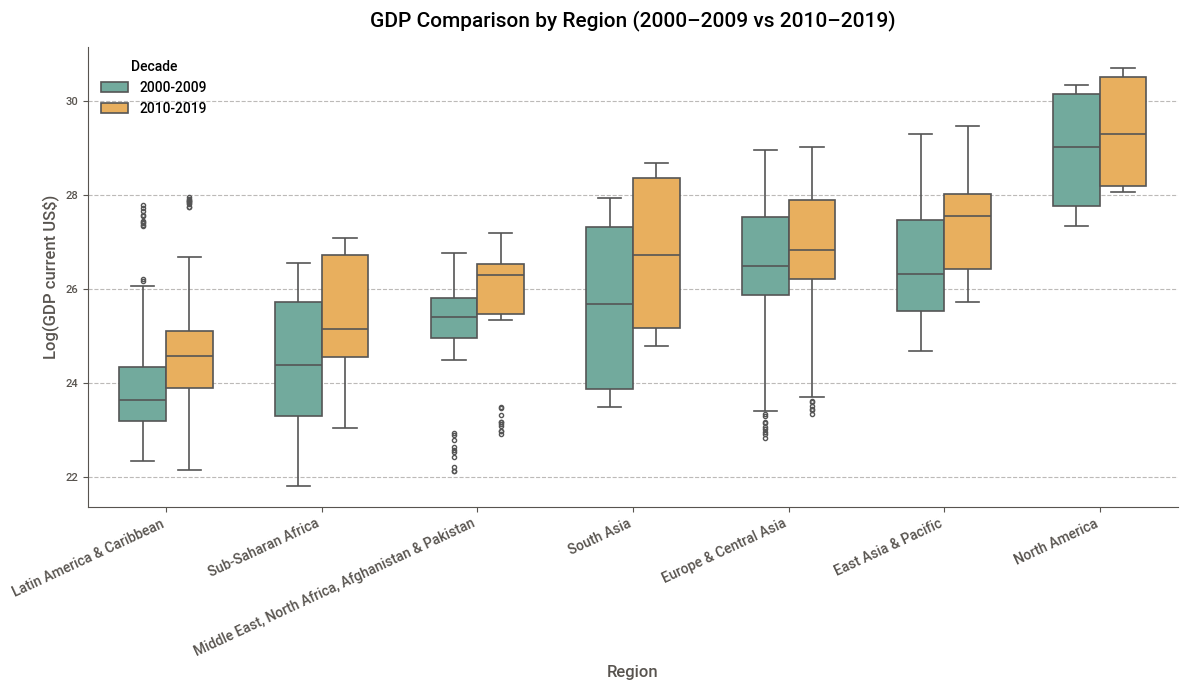

In [164]:
# --- Filter only for two decades ---
df_compare = df_gdp[df_gdp["year_range"].isin(["2000-2009", "2010-2019"])].copy()

# --- Re-define year_range categories so Seaborn only uses these two ---
df_compare["year_range"] = pd.Categorical(
    df_compare["year_range"], 
    categories=["2000-2009", "2010-2019"]
)

# --- Sort regions by median GDP ---
order = (
    df_compare.groupby("Region")["GDP_current_US"]
    .median()
    .sort_values(ascending=True)
    .index
)

# --- Plot ---
plt.figure(figsize=(12,7))  # wider figure gives more horizontal spacing

sns.boxplot(
    data=df_compare,
    x="Region",
    y=np.log1p(df_compare["GDP_current_US"]),
    hue="year_range",
    order=order,
    palette=["#69b3a2", "#ffb347"],
    width=0.6,          # thinner boxes → more space between groups
    linewidth=1.2,
    fliersize=3,
    dodge=True          # ensures grouped boxes (one per decade per region)
)

# --- Labels & title ---
plt.title("GDP Comparison by Region (2000–2009 vs 2010–2019)", fontsize=15, weight="bold", pad=15)
plt.xlabel("Region", fontsize=12)
plt.ylabel("Log(GDP current US$)", fontsize=12)

# --- X-axis readability ---
plt.xticks(rotation=25, ha="right", fontsize=10)

# --- Legend (only color coding) ---
plt.legend(title="Decade", loc="upper left", frameon=False)

# --- Grid & spacing tweaks ---
sns.despine()
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.subplots_adjust(bottom=0.2, left=0.1, right=0.98, top=0.9, wspace=0.4)  # control spacing
plt.tight_layout()

plt.show()


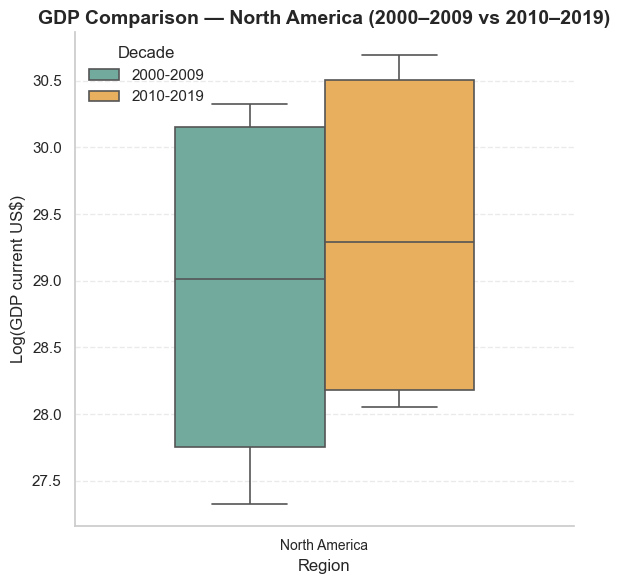

In [320]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Filter for the two decades ---
df_compare = df_gdp[df_gdp["year_range"].isin(["2000-2009", "2010-2019"])].copy()

# Restrict to **North America only**
df_na = df_compare[df_compare["Region"] == "North America"].copy()

# Ensure categorical ordering for decades
df_na["year_range"] = pd.Categorical(
    df_na["year_range"],
    categories=["2000-2009", "2010-2019"]
)

plt.figure(figsize=(6,6))

sns.boxplot(
    data=df_na,
    x="Region",
    y=np.log1p(df_na["GDP_current_US"]),
    hue="year_range",
    palette=["#69b3a2", "#ffb347"],
    width=0.6,
    linewidth=1.2,
    fliersize=3,
    dodge=True
)

plt.title("GDP Comparison — North America (2000–2009 vs 2010–2019)",
          fontsize=14, weight="bold")
plt.xlabel("Region", fontsize=12)
plt.ylabel("Log(GDP current US$)", fontsize=12)

plt.xticks(rotation=0, fontsize=10)
plt.legend(title="Decade", frameon=False)

sns.despine()
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()

plt.show()


## Is there a significant difference in mean GDP across regions during a given decade?

ANOVA (2000–2009):
               sum_sq     df          F        PR(>F)
C(Region)   933.49048    6.0  80.977631  7.467120e-73
Residual   1081.68790  563.0        NaN           NaN 

ANOVA (2010–2019):
               sum_sq     df          F        PR(>F)
C(Region)  745.753150    6.0  72.890308  3.845827e-67
Residual   961.729998  564.0        NaN           NaN 



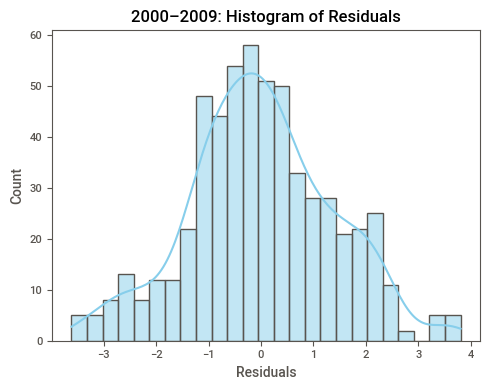

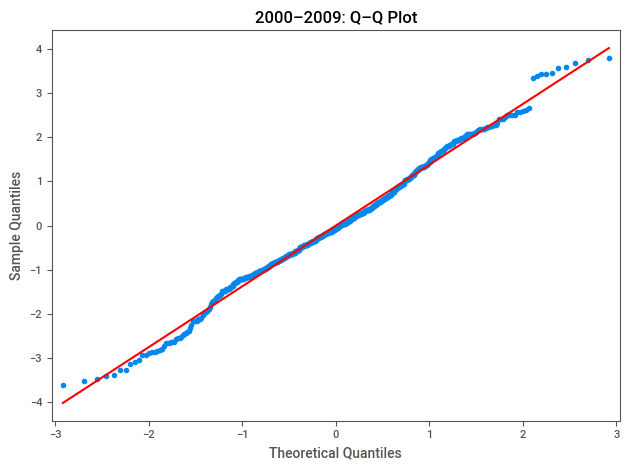

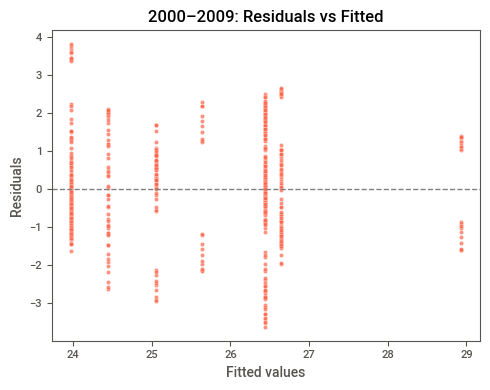

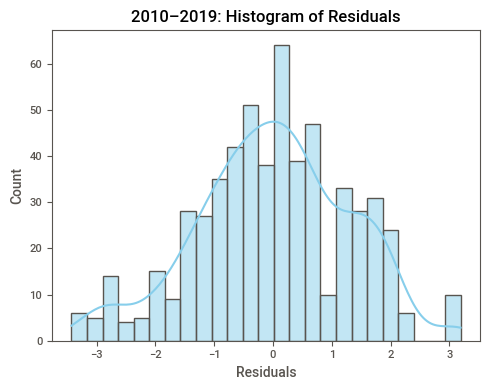

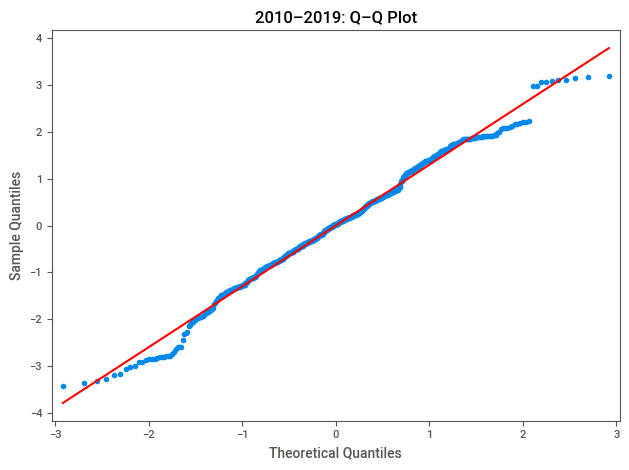

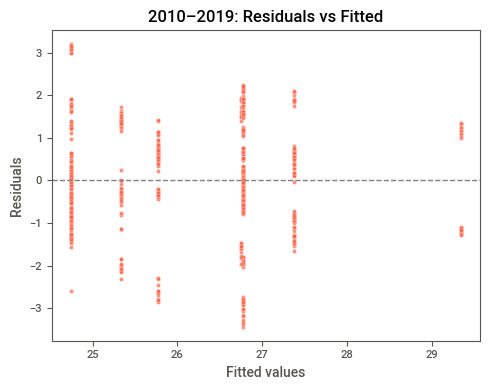

In [168]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# --- Filter by decade ---
df_2000s = df_gdp[df_gdp["year_range"] == "2000-2009"].copy()
df_2010s = df_gdp[df_gdp["year_range"] == "2010-2019"].copy()

# --- Fit one-way ANOVA model for 2000s ---
model_2000 = ols('np.log1p(GDP_current_US) ~ C(Region)', data=df_2000s).fit()
anova_2000 = sm.stats.anova_lm(model_2000, typ=2)
print("ANOVA (2000–2009):")
print(anova_2000, "\n")

# --- Fit one-way ANOVA model for 2010s ---
model_2010 = ols('np.log1p(GDP_current_US) ~ C(Region)', data=df_2010s).fit()
anova_2010 = sm.stats.anova_lm(model_2010, typ=2)
print("ANOVA (2010–2019):")
print(anova_2010, "\n")

# --- Function for residual diagnostics ---
def plot_residual_diagnostics(model, title_prefix):
    residuals = model.resid
    fitted = model.fittedvalues

    # Histogram
    plt.figure(figsize=(5,4))
    sns.histplot(residuals, bins=25, kde=True, color="skyblue")
    plt.title(f"{title_prefix}: Histogram of Residuals")
    plt.xlabel("Residuals")
    plt.tight_layout()
    plt.show()

    # Q–Q plot
    sm.qqplot(residuals, line='s')
    plt.title(f"{title_prefix}: Q–Q Plot")
    plt.tight_layout()
    plt.show()

    # Residuals vs Fitted
    plt.figure(figsize=(5,4))
    sns.scatterplot(x=fitted, y=residuals, color="tomato", alpha=0.7)
    plt.axhline(0, color="gray", linestyle="--", lw=1)
    plt.title(f"{title_prefix}: Residuals vs Fitted")
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.tight_layout()
    plt.show()

# --- Generate residual plots for each model ---
plot_residual_diagnostics(model_2000, "2000–2009")
plot_residual_diagnostics(model_2010, "2010–2019")


## is there significant difference between mean gdp of north america between these decades?

ANOVA for North America (2000s vs 2010s):
                      sum_sq    df             F        PR(>F)
C(year_range)  101845.414239   6.0  10933.149872  3.514230e-53
Residual           58.996809  38.0           NaN           NaN


/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 2
  warnings.warn('covariance of constraints does not have full '


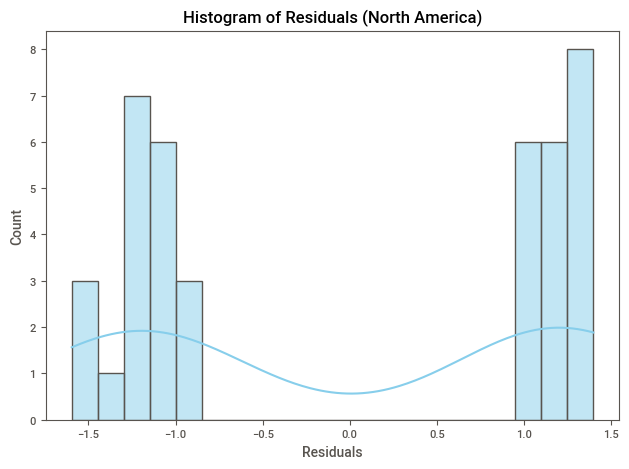

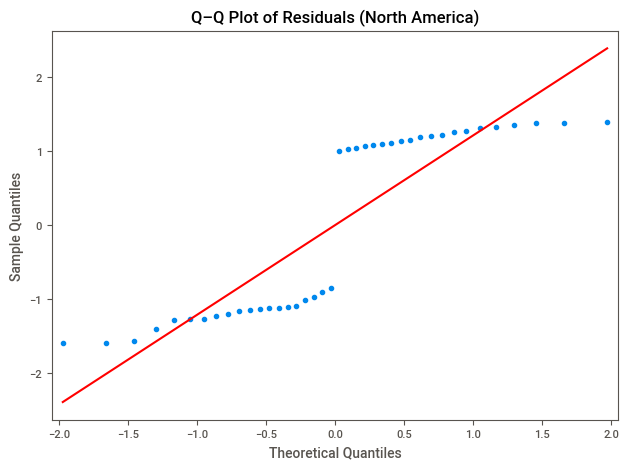

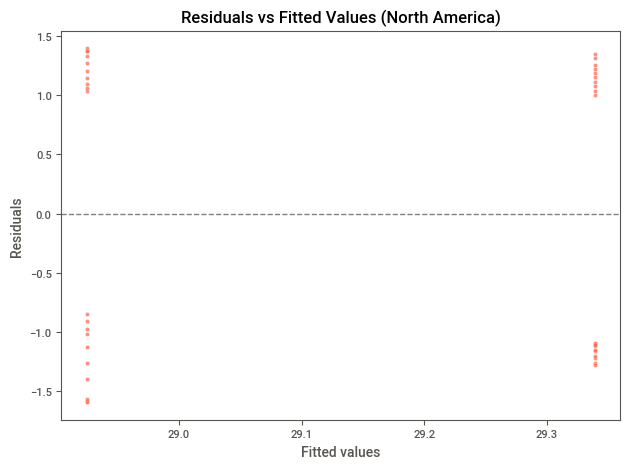

In [171]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

# --- Filter for North America and decades of interest ---
df_na = df_gdp[
    (df_gdp["Region"] == "North America") &
    (df_gdp["year_range"].isin(["2000-2009", "2010-2019"]))
].copy()

# --- Fit one-way ANOVA model (factor: decade) ---
model_na = ols('np.log1p(GDP_current_US) ~ C(year_range)', data=df_na).fit()
anova_na = sm.stats.anova_lm(model_na, typ=2)
print("ANOVA for North America (2000s vs 2010s):")
print(anova_na)

# --- Extract residuals and fitted values ---
residuals = model_na.resid
fitted = model_na.fittedvalues

# --- Plot residual diagnostics ---
# 1. Histogram
sns.histplot(residuals, bins=20, kde=True, color="skyblue")
plt.title("Histogram of Residuals (North America)")
plt.xlabel("Residuals")
plt.tight_layout()
plt.show()

# 2. Q–Q Plot
sm.qqplot(residuals, line='s')
plt.title("Q–Q Plot of Residuals (North America)")
plt.tight_layout()
plt.show()

# 3. Residuals vs Fitted
sns.scatterplot(x=fitted, y=residuals, color="tomato", alpha=0.7)
plt.axhline(0, color="gray", linestyle="--", lw=1)
plt.title("Residuals vs Fitted Values (North America)")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()


Shapiro–Wilk Test Statistic: 0.7542
p-value: 0.0000
⚠️ Residuals deviate from normality (reject H₀).


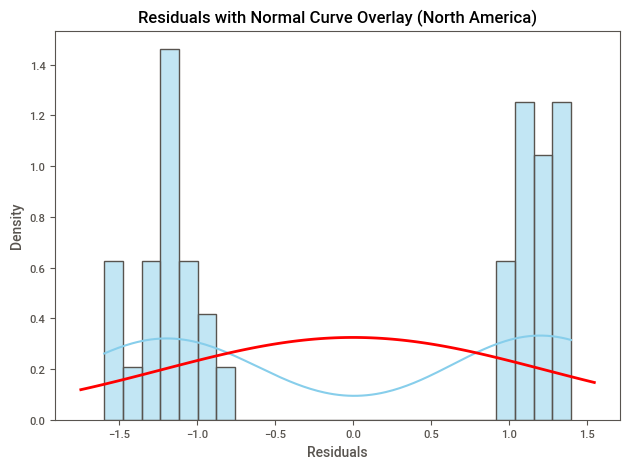

In [173]:
from scipy.stats import shapiro

# --- Shapiro–Wilk test for normality ---
stat, p = shapiro(residuals)
print(f"Shapiro–Wilk Test Statistic: {stat:.4f}")
print(f"p-value: {p:.4f}")

if p > 0.05:
    print("✅ Residuals appear approximately normal (fail to reject H₀).")
else:
    print("⚠️ Residuals deviate from normality (reject H₀).")


import scipy.stats as stats

sns.histplot(residuals, bins=25, kde=True, stat='density', color='skyblue')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
plt.plot(x, stats.norm.pdf(x, residuals.mean(), residuals.std()), color='red', lw=2)
plt.title("Residuals with Normal Curve Overlay (North America)")
plt.xlabel("Residuals")
plt.tight_layout()
plt.show()


Countries in North America (filtered): ['Canada' 'United States']
Year-range levels: ['2000-2009', '2010-2019']


/var/folders/64/4f9k2wyx0r14830_8g7xntcw0000gn/T/ipykernel_89785/3039784479.py:13: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df_na_decades["year_range"]):


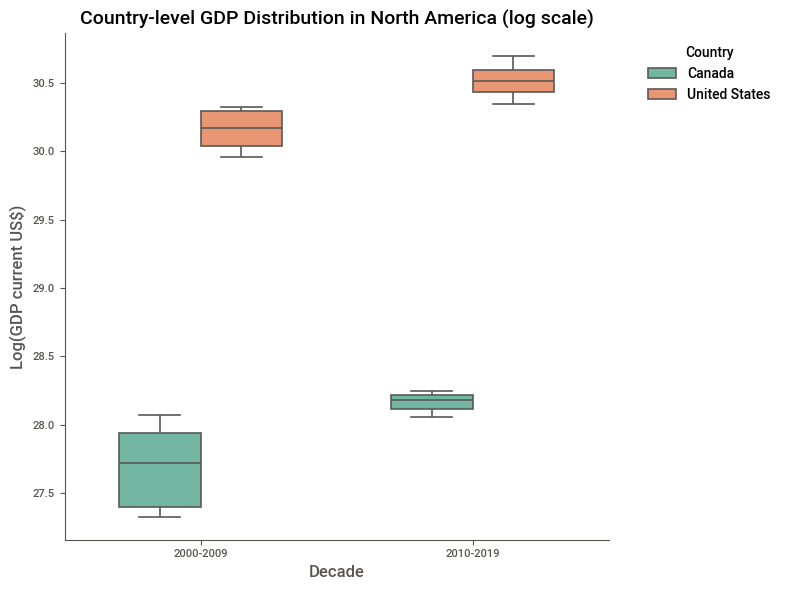


Mean log(GDP) by country and decade:
year_range     2000-2009  2010-2019
country                            
Canada            27.694     28.165
United States     30.156     30.513


/var/folders/64/4f9k2wyx0r14830_8g7xntcw0000gn/T/ipykernel_89785/3039784479.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["country", "year_range"])["log_GDP"]


In [180]:
# --- Filter directly from the main dataset ---
df_na_decades = df_gdp.loc[
    (df_gdp["Region"] == "North America")
    & (df_gdp["year_range"].isin(["2000-2009", "2010-2019"]))
].copy()

# --- Ensure only the two categories are kept and ordered ---
if pd.api.types.is_categorical_dtype(df_na_decades["year_range"]):
    df_na_decades["year_range"] = (
        df_na_decades["year_range"]
        .cat.remove_unused_categories()
        .cat.reorder_categories(["2000-2009", "2010-2019"], ordered=True)
    )
else:
    df_na_decades["year_range"] = pd.Categorical(
        df_na_decades["year_range"],
        categories=["2000-2009", "2010-2019"],
        ordered=True
    )

# --- Drop missing values just in case ---
df_na_decades = df_na_decades.dropna(subset=["GDP_current_US", "year_range", "country"])

# --- Quick sanity check ---
print("Countries in North America (filtered):", df_na_decades["country"].unique())
print("Year-range levels:", df_na_decades["year_range"].cat.categories.tolist())

# --- Plot: Country-level GDP distributions (same scale as residual plots) ---
plt.figure(figsize=(8, 6))  # 👈 bigger figure for consistency with Step 1 & 2
sns.boxplot(
    data=df_na_decades,
    x="year_range",
    y=np.log1p(df_na_decades["GDP_current_US"]),
    hue="country",
    palette="Set2",
    width=0.6,
    linewidth=1.2
)
plt.title("Country-level GDP Distribution in North America (log scale)", fontsize=14, weight="bold")
plt.xlabel("Decade", fontsize=12)
plt.ylabel("Log(GDP current US$)", fontsize=12)
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
sns.despine()
plt.tight_layout()
plt.show()

# --- Compact summary (no long dump) ---
summary = (
    df_na_decades
    .assign(log_GDP=np.log1p(df_na_decades["GDP_current_US"]))
    .groupby(["country", "year_range"])["log_GDP"]
    .mean()
    .unstack()
    .round(3)
)

print("\nMean log(GDP) by country and decade:")
print(summary.to_string())


One-way ANOVA: United States (2000–2009 vs 2010–2019)
               sum_sq    df        F  PR(>F)
C(year_range)  0.6369   1.0  38.4669     0.0
Residual       0.2980  18.0      NaN     NaN

F-statistic = 38.47, p-value = 0.00001


/var/folders/64/4f9k2wyx0r14830_8g7xntcw0000gn/T/ipykernel_89785/786391069.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  F_val = anova_us["F"][0]
/var/folders/64/4f9k2wyx0r14830_8g7xntcw0000gn/T/ipykernel_89785/786391069.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_val = anova_us["PR(>F)"][0]


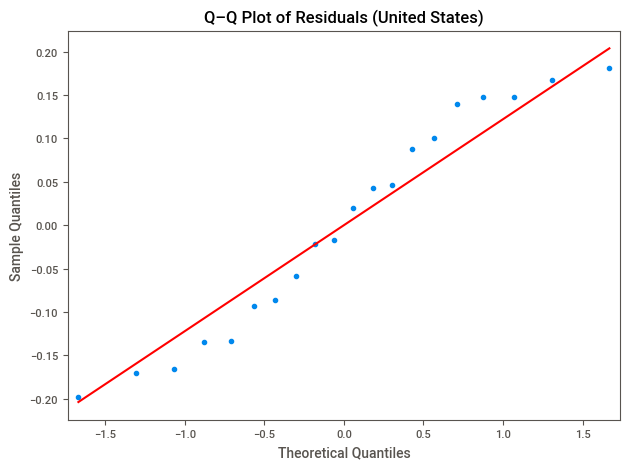

Shapiro–Wilk p-value: 0.1733
✅ Residuals approximately normal.


In [182]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import shapiro

# --- Filter dataset for the United States and two decades ---
df_us = df_gdp.loc[
    (df_gdp["country"] == "United States") &
    (df_gdp["year_range"].isin(["2000-2009", "2010-2019"]))
].copy()

# --- Ensure correct ordering for decades ---
df_us["year_range"] = pd.Categorical(
    df_us["year_range"],
    categories=["2000-2009", "2010-2019"],
    ordered=True
)

# --- Fit one-way ANOVA model ---
model_us = ols('np.log1p(GDP_current_US) ~ C(year_range)', data=df_us).fit()
anova_us = sm.stats.anova_lm(model_us, typ=2)

print("One-way ANOVA: United States (2000–2009 vs 2010–2019)")
print(anova_us.round(4))

# --- Extract stats for report ---
F_val = anova_us["F"][0]
p_val = anova_us["PR(>F)"][0]
print(f"\nF-statistic = {F_val:.2f}, p-value = {p_val:.5f}")

# --- Q–Q plot of residuals ---
residuals = model_us.resid
sm.qqplot(residuals, line='s')
plt.title("Q–Q Plot of Residuals (United States)", fontsize=12, weight="bold")
plt.tight_layout()
plt.show()

# --- Shapiro–Wilk normality test (optional numeric check) ---
stat, p_shapiro = shapiro(residuals)
print(f"Shapiro–Wilk p-value: {p_shapiro:.4f}")
if p_shapiro > 0.05:
    print("✅ Residuals approximately normal.")
else:
    print("⚠️ Slight deviation from perfect normality — visually inspect Q–Q plot.")


## Which region saw the most growth in GDP and also comparing the internal standard deviation across countries?

/var/folders/64/4f9k2wyx0r14830_8g7xntcw0000gn/T/ipykernel_89785/3559895449.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_compare.groupby(["Region", "year_range"])["GDP_current_US"]
/var/folders/64/4f9k2wyx0r14830_8g7xntcw0000gn/T/ipykernel_89785/3559895449.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(region_pivot["Region"], rotation=25, ha="right")
/var/folders/64/4f9k2wyx0r14830_8g7xntcw0000gn/T/ipykernel_89785/3559895449.py:68: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from font(s) Roboto.
  plt.tight_layout()
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from font(s) 

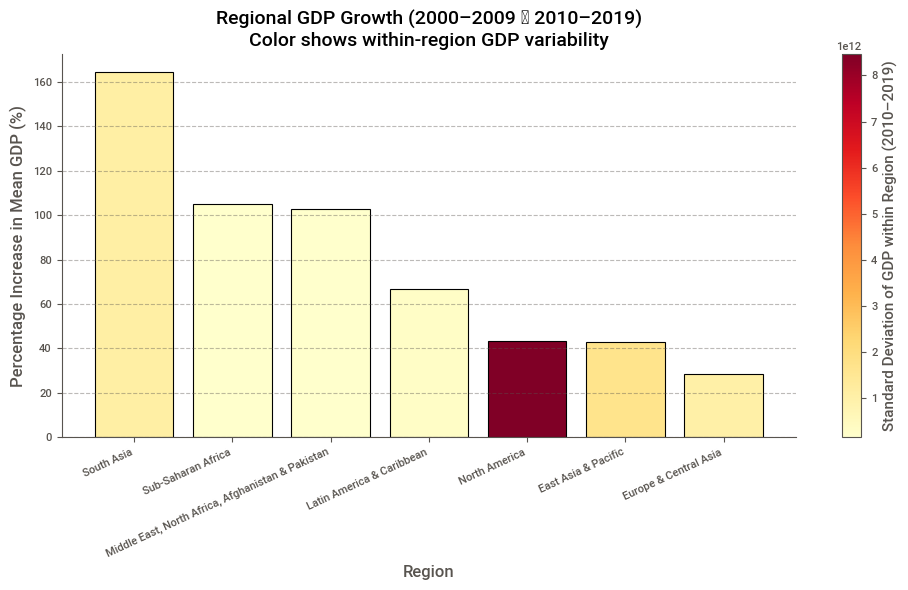


Regional GDP growth and variability summary (logically interpretable):
                                              Region  pct_increase  \
5                                         South Asia        164.24   
6                                 Sub-Saharan Africa        105.03   
3  Middle East, North Africa, Afghanistan & Pakistan        102.93   
2                          Latin America & Caribbean         66.79   
4                                      North America         43.49   
0                                East Asia & Pacific         42.79   
1                              Europe & Central Asia         28.29   

      std_2010s  
5  1.115272e+12  
6  1.887842e+11  
3  1.574346e+11  
2  2.938365e+11  
4  8.460263e+12  
0  1.685669e+12  
1  1.055157e+12  


In [189]:
# --- Filter only for the two decades ---
df_compare = df_gdp.loc[
    df_gdp["year_range"].isin(["2000-2009", "2010-2019"])
].copy()

# --- Compute mean and standard deviation per region per decade ---
region_stats = (
    df_compare.groupby(["Region", "year_range"])["GDP_current_US"]
    .agg(mean="mean", std="std")
    .reset_index()
)

# --- Pivot to get both decades side by side ---
region_pivot = region_stats.pivot(index="Region", columns="year_range", values=["mean", "std"])

# --- Flatten column MultiIndex dynamically ---
region_pivot.columns = [f"{a}_{b.replace('-', '')}" for a, b in region_pivot.columns]
region_pivot = region_pivot.reset_index()

# --- Calculate % GDP increase from 2000s to 2010s ---
region_pivot["pct_increase"] = (
    (region_pivot["mean_20102019"] - region_pivot["mean_20002009"]) /
    region_pivot["mean_20002009"] * 100
)

# --- Get SD of 2010s for color encoding ---
region_pivot["std_2010s"] = region_pivot["std_20102019"]

# --- Sort by GDP growth ---
region_pivot = region_pivot.sort_values("pct_increase", ascending=False)

# --- Normalize color based on SD (higher SD = darker color) ---
norm = plt.Normalize(region_pivot["std_2010s"].min(), region_pivot["std_2010s"].max())
colors = plt.cm.YlOrRd(norm(region_pivot["std_2010s"]))

# --- Plot setup ---
fig, ax = plt.subplots(figsize=(10,6))
bars = ax.bar(
    x=region_pivot["Region"],
    height=region_pivot["pct_increase"],
    color=colors,
    edgecolor="black",
    linewidth=0.8
)

# --- Title and labels ---
ax.set_title(
    "Regional GDP Growth (2000–2009 → 2010–2019)\nColor shows within-region GDP variability",
    fontsize=14, weight="bold"
)
ax.set_xlabel("Region", fontsize=12)
ax.set_ylabel("Percentage Increase in Mean GDP (%)", fontsize=12)
ax.set_xticklabels(region_pivot["Region"], rotation=25, ha="right")
ax.grid(axis="y", linestyle="--", alpha=0.4)
sns.despine(ax=ax)

# --- Add colorbar (standard deviation of GDP) ---
sm = plt.cm.ScalarMappable(cmap="YlOrRd", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Standard Deviation of GDP within Region (2010–2019)", fontsize=11)

plt.tight_layout()
plt.show()

# --- Optional: Print summary stats ---
print("\nRegional GDP growth and variability summary (logically interpretable):")
print(region_pivot[["Region", "pct_increase", "std_2010s"]].round(2))


In [195]:
dataset3 = dataset3[dataset3["year"]>1992]

In [200]:
# Filter for countries with no missing values in 'inflation_annual%'
no_missing_inflation = (
    dataset3
    .groupby("country")["inflation_annual%"]
    .apply(lambda x: x.notnull().all())   # True if no nulls for that country
)

# Get only countries where this is True
countries_no_missing_inflation = no_missing_inflation[no_missing_inflation].index.tolist()

print(f"✅ Countries with NO missing values in 'inflation_annual%': {len(countries_no_missing_inflation)}")
print(countries_no_missing_inflation)

✅ Countries with NO missing values in 'inflation_annual%': 133
['Albania', 'Algeria', 'Angola', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas, The', 'Bahrain', 'Bangladesh', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon', 'Canada', 'Cayman Islands', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt, Arab Rep.', 'El Salvador', 'Equatorial Guinea', 'Estonia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia, The', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea-Bissau', 'Haiti', 'Honduras', 'Hong Kong SAR, China', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran, Islamic Rep.', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kenya', 'Korea, Rep.', 'Kuwait', 'Lao PDR', 'Latvia', 'Libya', 'Lithuania', 'Luxembourg', 'Macao SAR

In [201]:
inflation_cols = ['Albania', 'Algeria', 'Angola', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas, The', 'Bahrain', 'Bangladesh', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon', 'Canada', 'Cayman Islands', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt, Arab Rep.', 'El Salvador', 'Equatorial Guinea', 'Estonia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia, The', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea-Bissau', 'Haiti', 'Honduras', 'Hong Kong SAR, China', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran, Islamic Rep.', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kenya', 'Korea, Rep.', 'Kuwait', 'Lao PDR', 'Latvia', 'Libya', 'Lithuania', 'Luxembourg', 'Macao SAR, China', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Mauritania', 'Mauritius', 'Mexico', 'Moldova', 'Mongolia', 'Morocco', 'Nepal', 'Netherlands', 'New Zealand', 'Niger', 'Nigeria', 'Norway', 'Pakistan', 'Panama', 'Papua New Guinea', 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Qatar', 'Romania', 'Russian Federation', 'Samoa', 'Saudi Arabia', 'Senegal', 'Singapore', 'Slovak Republic', 'Slovenia', 'Solomon Islands', 'South Africa', 'Spain', 'Sri Lanka', 'St. Kitts and Nevis', 'St. Lucia', 'St. Vincent and the Grenadines', 'Sudan', 'Sweden', 'Switzerland', 'Tanzania', 'Thailand', 'Togo', 'Tonga', 'Trinidad and Tobago', 'Tunisia', 'Ukraine', 'United Kingdom', 'United States', 'Uruguay', 'Vanuatu', 'Zambia']

In [203]:
df_inflation = dataset3[dataset3["country"].isin(inflation_cols)]

In [207]:
import pandas as pd

# --- Ensure year column is numeric ---
df_inflation["year"] = pd.to_numeric(df_inflation["year"], errors="coerce")

# --- Create year_range column only for the last two decades ---
df_inflation["year_range"] = pd.cut(
    df_inflation["year"],
    bins=[2000, 2010, 2020],
    right=False,
    labels=["2000-2009", "2010-2019"]
)

# --- Filter to keep only these two decades ---
df_inflation = df_inflation[df_inflation["year_range"].notna()].copy()

df_inflation.head()


/var/folders/64/4f9k2wyx0r14830_8g7xntcw0000gn/T/ipykernel_89785/3504153970.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inflation["year"] = pd.to_numeric(df_inflation["year"], errors="coerce")
/var/folders/64/4f9k2wyx0r14830_8g7xntcw0000gn/T/ipykernel_89785/3504153970.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inflation["year_range"] = pd.cut(


,country,year,Region,GDP_current_US,inflation_annual%,real_interest_rate,tax_revenue%,expense%,central_goverment_debt%,trade_in_services%,electric_power_consumption,multidimensional_poverty_headcount_ratio%,gini_index,Income group,human_capital_index,life_expectancy_at_birth,birth_rate,death_rate,population,population_density,rural_population,government_expenditure_on_education%,government_health_expenditure%,goverment_effectiveness_estimate,control_of_corruption_estimate,research_and_development_expenditure%,logistic_performance_index,doing_business,year_range
232,Albania,2000,Europe & Central Asia,3.480355e+09,0.050018,15.575412,NaN,NaN,NaN,25.531876,1449.647413,NaN,NaN,Upper middle income,NaN,75.404,17.076,5.798,3089027.0,112.738212,1799636.0,3.43017,2.765835,-0.917780,-0.855564,NaN,NaN,NaN,2000-2009
233,Albania,2001,Europe & Central Asia,3.922101e+09,3.107588,15.261707,NaN,NaN,NaN,25.312965,1351.230796,NaN,NaN,Upper middle income,NaN,75.639,16.120,5.872,3060173.0,111.685146,1761589.0,3.45870,2.753284,NaN,NaN,NaN,NaN,NaN,2000-2009
234,Albania,2002,Europe & Central Asia,4.348068e+09,7.770526,11.246478,16.484242,24.831878,NaN,26.959328,1578.165919,NaN,31.7,Upper middle income,NaN,75.890,15.209,5.953,3051010.0,111.350730,1723790.0,3.11780,2.588679,-0.624333,-0.845341,NaN,NaN,NaN,2000-2009
235,Albania,2003,Europe & Central Asia,5.611496e+09,0.484003,8.623874,17.196138,22.901376,NaN,27.598163,1469.264539,NaN,NaN,Upper middle income,NaN,76.142,14.668,6.057,3039616.0,110.934891,1684768.0,3.13823,2.670353,-0.563987,-0.853787,NaN,NaN,NaN,2000-2009
236,Albania,2004,Europe & Central Asia,7.184686e+09,2.280019,8.346054,17.965076,22.793922,NaN,30.002777,1797.525487,NaN,NaN,Upper middle income,NaN,76.376,13.978,6.181,3026939.0,110.472226,1645111.0,3.22752,2.820827,-0.408372,-0.723732,NaN,NaN,NaN,2000-2009


/var/folders/64/4f9k2wyx0r14830_8g7xntcw0000gn/T/ipykernel_89785/3774300396.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_inf_pop.groupby(["Region", "year_range"])
/var/folders/64/4f9k2wyx0r14830_8g7xntcw0000gn/T/ipykernel_89785/3774300396.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x["inflation_annual%"].corr(x["population"]))


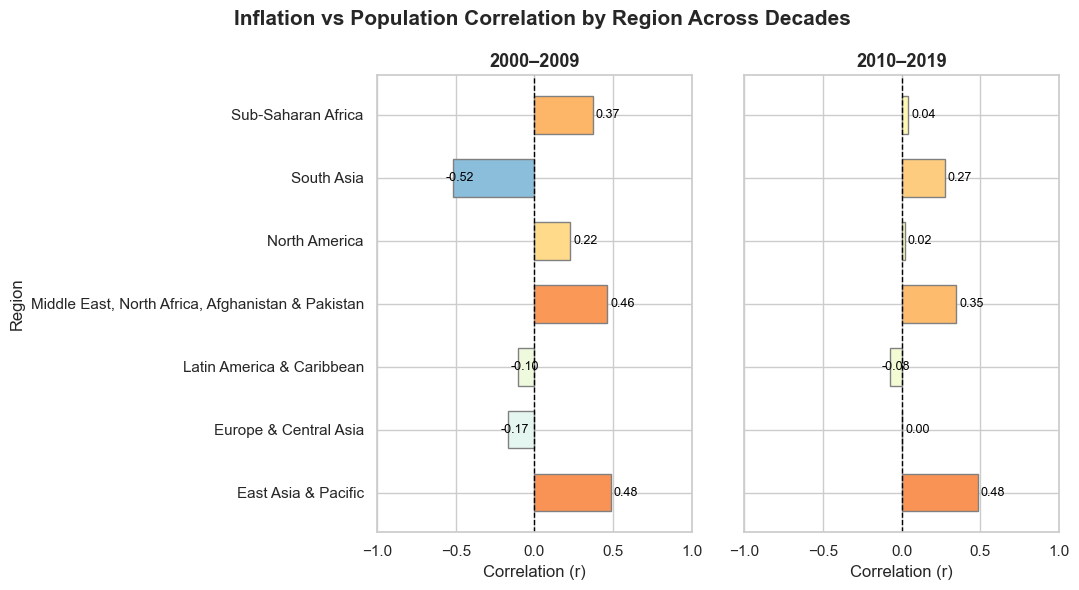

In [221]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- Merge inflation & population data ---
df_inf_pop = pd.merge(
    df_inflation[["country", "year", "Region", "inflation_annual%"]],
    df_gdp[["country", "year", "population"]],
    on=["country", "year"],
    how="inner"
)

# --- Clean data ---
df_inf_pop = df_inf_pop.replace([np.inf, -np.inf], np.nan)
df_inf_pop = df_inf_pop.dropna(subset=["inflation_annual%", "population"])
df_inf_pop = df_inf_pop[df_inf_pop["inflation_annual%"].between(-50, 200)]
df_inf_pop = df_inf_pop[df_inf_pop["population"] > 0]

# --- Add decade bins ---
df_inf_pop["year"] = pd.to_numeric(df_inf_pop["year"], errors="coerce")
df_inf_pop["year_range"] = pd.cut(
    df_inf_pop["year"],
    bins=[2000, 2010, 2020],
    right=False,
    labels=["2000–2009", "2010–2019"]
)

# --- Compute correlations ---
corrs = (
    df_inf_pop.groupby(["Region", "year_range"])
    .apply(lambda x: x["inflation_annual%"].corr(x["population"]))
    .reset_index(name="corr_inflation_population")
)

# --- Consistent order for both decades ---
regions_order = sorted(corrs["Region"].unique())

# --- Aesthetic settings ---
sns.set(style="whitegrid")
palette = sns.color_palette("RdYlBu_r", as_cmap=True)

# --- Create side-by-side plots ---
fig, axes = plt.subplots(1, 2, figsize=(11, 6), sharey=True)

for ax, decade in zip(axes, ["2000–2009", "2010–2019"]):
    data = corrs[corrs["year_range"] == decade].sort_values("Region")
    colors = [palette((v + 1) / 2) for v in data["corr_inflation_population"]]  # map [-1,1] → [0,1]

    bars = ax.barh(
        data["Region"], data["corr_inflation_population"],
        color=colors, edgecolor="grey", height=0.6
    )

    # Add correlation value labels
    for bar, val in zip(bars, data["corr_inflation_population"]):
        ax.text(
            val + 0.02 if val >= 0 else val - 0.05,
            bar.get_y() + bar.get_height()/2,
            f"{val:.2f}",
            va="center", fontsize=9, color="black"
        )

    ax.axvline(0, color="black", lw=1, linestyle="--")
    ax.set_title(decade, fontsize=13, weight="bold")
    ax.set_xlim(-1, 1)
    ax.set_xlabel("Correlation (r)")
    if decade == "2000–2009":
        ax.set_ylabel("Region")
    else:
        ax.set_ylabel("")

# --- Global title ---
fig.suptitle("Inflation vs Population Correlation by Region Across Decades",
             fontsize=15, weight="bold", y=0.98)
plt.tight_layout()
plt.show()


In [241]:

# Ensure numeric years
df_inflation["year"] = pd.to_numeric(df_inflation["year"], errors="coerce")

# Get min & max year
start_year = int(df_inflation["year"].min())
end_year = int(df_inflation["year"].max())

# Make 4-year bins
df_inflation["year_range_4yr"] = pd.cut(
    df_inflation["year"],
    bins=range(start_year, end_year + 4, 4),
    right=False,
    labels=[f"{y}-{y+3}" for y in range(start_year, end_year, 4)]
)

df_inflation["year_range_4yr"].unique()


['2000-2003', '2004-2007', '2008-2011', '2012-2015', '2016-2019']
Categories (5, object): ['2000-2003' < '2004-2007' < '2008-2011' < '2012-2015' < '2016-2019']

In [326]:
dataset.isnull().sum()

country                                          0
date                                             0
agricultural_land%                            1465
forest_land%                                  6166
land_area                                     1321
avg_precipitation                             2750
trade_in_services%                            5668
control_of_corruption_estimate                8034
control_of_corruption_std                     8034
access_to_electricity%                        6661
renewvable_energy_consumption%                6190
electric_power_consumption                    6709
CO2_emisions                                  6696
other_greenhouse_emisions                     6696
population_density                            1321
inflation_annual%                             4244
real_interest_rate                            8164
risk_premium_on_lending                      10056
research_and_development_expenditure%        10158
central_goverment_debt%        

In [245]:
south_asia["country"].value_counts()

country
Bangladesh    20
Bhutan        20
India         20
Maldives      20
Nepal         20
Sri Lanka     20
Name: count, dtype: int64

/var/folders/64/4f9k2wyx0r14830_8g7xntcw0000gn/T/ipykernel_89785/1131191463.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  south_asia.groupby(["country", "year_range_2_5yr"])["inflation_annual%"]


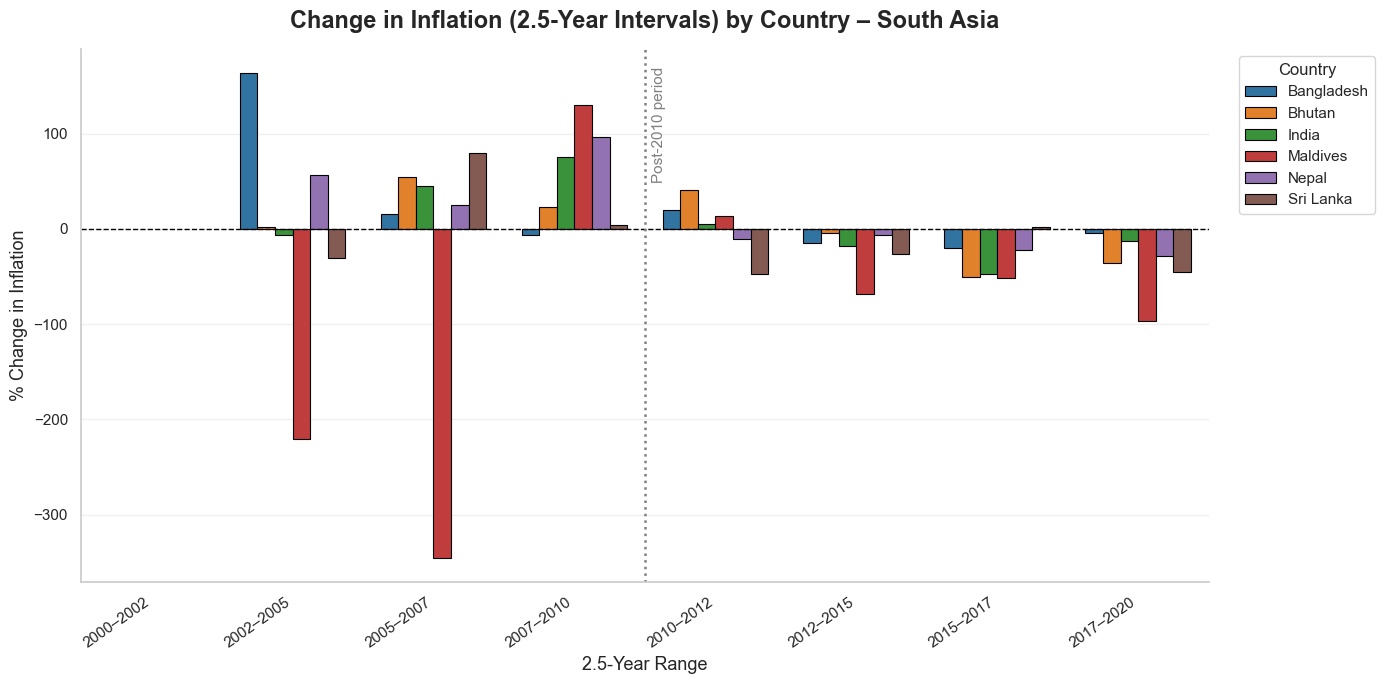

In [319]:
# --- Ensure numeric types ---
df_inflation["year"] = pd.to_numeric(df_inflation["year"], errors="coerce")
df_inflation["inflation_annual%"] = pd.to_numeric(df_inflation["inflation_annual%"], errors="coerce")

# --- Define 2.5-year bins ---
start_year = int(np.floor(df_inflation["year"].min()))
end_year = int(np.ceil(df_inflation["year"].max()))
bin_edges = np.arange(start_year, end_year + 2.5, 2.5)
labels = [f"{int(b)}–{int(b+2.5)}" for b in bin_edges[:-1]]

df_inflation["year_range_2_5yr"] = pd.cut(
    df_inflation["year"], bins=bin_edges, labels=labels, right=False
)

# --- Focus on South Asia ---
south_asia = df_inflation[df_inflation["Region"] == "South Asia"].copy()

# --- Compute mean inflation per country & bin ---
infl_trends = (
    south_asia.groupby(["country", "year_range_2_5yr"])["inflation_annual%"]
    .mean()
    .reset_index()
)

# --- Calculate % change ---
infl_trends["infl_change_%"] = (
    infl_trends.groupby("country")["inflation_annual%"]
    .pct_change() * 100
)
infl_trends = infl_trends.dropna(subset=["infl_change_%"])

# --- Plot ---
plt.figure(figsize=(14,7))
sns.set_theme(style="whitegrid")
sns.barplot(
    data=infl_trends,
    x="year_range_2_5yr",
    y="infl_change_%",
    hue="country",
    palette="tab10",
    width=0.75,
    edgecolor="black",
    linewidth=0.8
)

# --- Styling ---
plt.axhline(0, color="black", linestyle="--", lw=1)
plt.title("Change in Inflation (2.5-Year Intervals) by Country – South Asia",
          fontsize=17, weight="bold", pad=15)
plt.xlabel("2.5-Year Range", fontsize=13)
plt.ylabel("% Change in Inflation", fontsize=13)
plt.xticks(rotation=35, ha="right", fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis="y", alpha=0.3)
plt.legend(title="Country", fontsize=11, title_fontsize=12, bbox_to_anchor=(1.02, 1), loc="upper left")

# --- Add vertical separator after "2010–2012" ---
labels = [tick.get_text() for tick in plt.gca().get_xticklabels()]
for i, label in enumerate(labels):
    if "2010" in label:
        plt.axvline(i + 0.5, color="gray", linestyle=":", lw=1.8)
        plt.text(i + 0.55, plt.ylim()[1]*0.9, "Post-2010 period", 
                 color="gray", fontsize=11, rotation=90, va="top")
        break

sns.despine()
plt.tight_layout()
plt.show()


/var/folders/64/4f9k2wyx0r14830_8g7xntcw0000gn/T/ipykernel_89785/39651196.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_filtered.groupby(["Region", "year_range"])


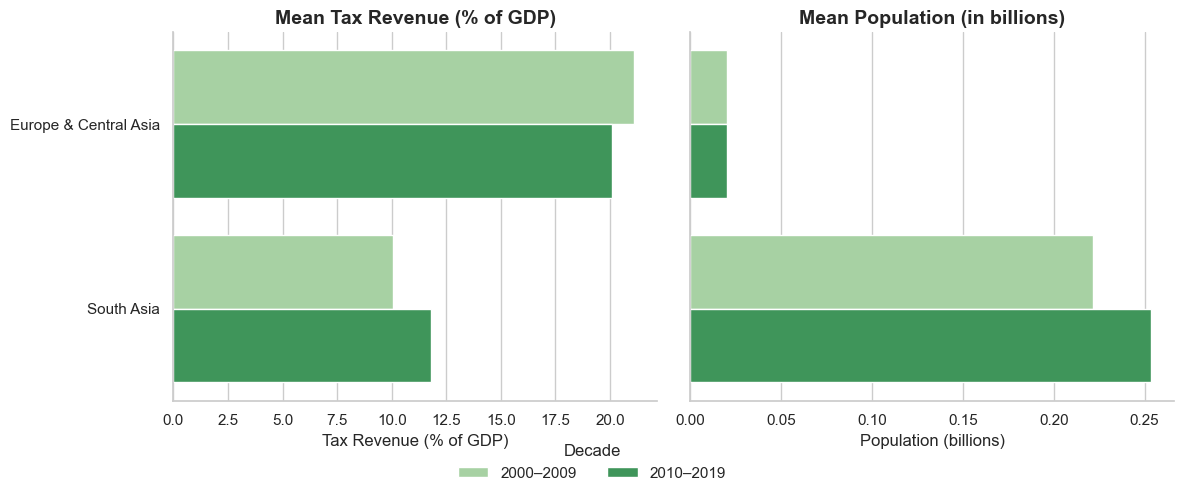

In [257]:


# --- Ensure numeric year ---
df_inflation["year"] = pd.to_numeric(df_inflation["year"], errors="coerce")

# --- Define decades ---
df_inflation["year_range"] = pd.cut(
    df_inflation["year"],
    bins=[1999, 2009, 2019],
    labels=["2000–2009", "2010–2019"],
    right=True
)

# --- Filter for South Asia and Europe & Central Asia ---
df_filtered = df_inflation[df_inflation["Region"].isin(["South Asia", "Europe & Central Asia"])]

# --- Aggregate mean values ---
region_tax_pop = (
    df_filtered.groupby(["Region", "year_range"])
    .agg(
        mean_population=("population", "mean"),
        mean_tax_revenue=("tax_revenue%", "mean")
    )
    .reset_index()
)

# --- Convert population to billions ---
region_tax_pop["population_billions"] = region_tax_pop["mean_population"] / 1e9

# --- Define order ---
region_order = ["Europe & Central Asia", "South Asia"]

# --- Define consistent colors ---
palette_decades = ["#a1d99b", "#31a354"]  # light green = 2000s, dark green = 2010s

# --- Create figure ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# --- Plot 1: Tax Revenue (% of GDP) ---
sns.barplot(
    data=region_tax_pop,
    x="mean_tax_revenue",
    y="Region",
    hue="year_range",
    order=region_order,
    palette=palette_decades,
    ax=axes[0]
)
axes[0].set_title("Mean Tax Revenue (% of GDP)", fontsize=14, weight="bold")
axes[0].set_xlabel("Tax Revenue (% of GDP)", fontsize=12)
axes[0].set_ylabel("")
axes[0].legend_.remove()  # remove local legend

# --- Plot 2: Population (in billions) ---
sns.barplot(
    data=region_tax_pop,
    x="population_billions",
    y="Region",
    hue="year_range",
    order=region_order,
    palette=palette_decades,
    ax=axes[1]
)
axes[1].set_title("Mean Population (in billions)", fontsize=14, weight="bold")
axes[1].set_xlabel("Population (billions)", fontsize=12)
axes[1].set_ylabel("")
axes[1].legend_.remove()  # remove duplicate legend

# --- Shared legend ---
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    title="Decade",
    loc="lower center",
    ncol=2,
    frameon=False,
    fontsize=11
)

sns.despine()
plt.tight_layout(rect=[0, 0.05, 1, 1])  # make space for shared legend
plt.show()


In [230]:
df_sa = df_inflation[df_inflation["Region"] == "South Asia"].copy()

summary_sa = (
    df_sa.groupby("year_range")["inflation_annual%"]
    .agg(["mean", "median", "std", "min", "max", "count"])
    .reset_index()
)
print(summary_sa)

  year_range      mean    median       std       min        max  count
0  2000-2009  5.788168  5.078283  4.186002 -1.685412  22.564496     60
1  2010-2019  6.072254  6.172083  2.998070 -0.133373  11.989390     60


/var/folders/64/4f9k2wyx0r14830_8g7xntcw0000gn/T/ipykernel_89785/3389000167.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sa.groupby("year_range")["inflation_annual%"]


In [234]:

from scipy.stats import ttest_ind

# --- Filter for India ---
df_india = df_inflation[df_inflation["country"] == "India"].copy()

# --- Summarize inflation by decade ---
summary_india = (
    df_india.groupby("year_range")["inflation_annual%"]
    .agg(["mean", "median", "std", "min", "max", "count"])
    .reset_index()
)
print("📊 Inflation summary for India:")
print(summary_india)


📊 Inflation summary for India:
  year_range      mean    median       std       min        max  count
0  2000-2009  5.530636  4.271748  2.403751  3.767252  10.882353     10
1  2010-2019  6.791541  5.806937  3.084352  3.328173  11.989390     10


/var/folders/64/4f9k2wyx0r14830_8g7xntcw0000gn/T/ipykernel_89785/2979887042.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_india.groupby("year_range")["inflation_annual%"]


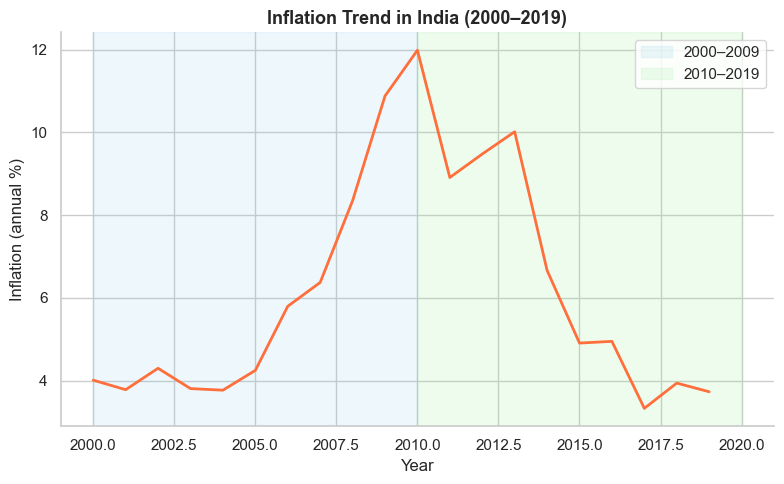

In [235]:
plt.figure(figsize=(8,5))
sns.lineplot(data=df_india, x="year", y="inflation_annual%", color="#ff6f3c", linewidth=2)
plt.axvspan(2000, 2010, color="skyblue", alpha=0.15, label="2000–2009")
plt.axvspan(2010, 2020, color="lightgreen", alpha=0.15, label="2010–2019")
plt.title("Inflation Trend in India (2000–2019)", fontsize=13, weight="bold")
plt.xlabel("Year")
plt.ylabel("Inflation (annual %)")
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()


In [266]:
# --- Filter for countries where poverty data is available ---
poverty_cols = ["multidimensional_poverty_headcount_ratio%", "GDP_current_US"]

# Keep rows where poverty AND GDP are not null
df_poverty = dataset.dropna(subset=poverty_cols).copy()

# Optional: keep only relevant time window (same as before)
df_poverty["year"] = pd.to_numeric(df_poverty["year"], errors="coerce")
df_poverty = df_poverty[df_poverty["year"] >= 1992]  # or adjust to match your GDP range

# --- Create decade bins like before ---
df_poverty["year_range"] = pd.cut(
    df_poverty["year"],
    bins=[1999, 2009, 2019],
    labels=["2000–2009", "2010–2019"],
    right=True
)

# --- Quick check ---
print("Number of records after filtering:", len(df_poverty))
print("Unique countries:", df_poverty['country'].nunique())
print("Regions covered:", df_poverty['Region'].unique())

# Optional preview
df_poverty.head()


Number of records after filtering: 433
Unique countries: 64
Regions covered: ['Middle East, North Africa, Afghanistan & Pakistan'
 'Europe & Central Asia' 'Sub-Saharan Africa' 'South Asia'
 'Latin America & Caribbean' 'East Asia & Pacific']


,country,date,agricultural_land%,forest_land%,land_area,avg_precipitation,trade_in_services%,control_of_corruption_estimate,control_of_corruption_std,access_to_electricity%,renewvable_energy_consumption%,electric_power_consumption,CO2_emisions,other_greenhouse_emisions,population_density,inflation_annual%,real_interest_rate,risk_premium_on_lending,research_and_development_expenditure%,central_goverment_debt%,tax_revenue%,expense%,goverment_effectiveness_estimate,goverment_effectiveness_std,human_capital_index,doing_business,time_to_get_operation_license,statistical_performance_indicators,individuals_using_internet%,logistic_performance_index,military_expenditure%,GDP_current_US,political_stability_estimate,political_stability_std,rule_of_law_estimate,rule_of_law_std,regulatory_quality_estimate,regulatory_quality_std,government_expenditure_on_education%,government_health_expenditure%,multidimensional_poverty_headcount_ratio%,gini_index,birth_rate,death_rate,life_expectancy_at_birth,population,rural_population,voice_and_accountability_estimate,voice_and_accountability_std,intentional_homicides,Income group,Region,null_count,year,year_range
56,Afghanistan,2016-01-01,58.123668,1.852782,652230.0,327.0,9.052921,-1.540353,0.165114,97.70,19.92,NaN,9294.93,30864.983630,53.104284,4.383892,17.583938,NaN,NaN,NaN,9.502653,43.922766,-1.290253,0.233016,NaN,NaN,NaN,37.222917,11.000000,2.141282,0.956772,1.811657e+10,-2.662156,0.217760,-1.520714,0.175974,-1.339695,0.197118,4.543970,0.600130,51.7,NaN,37.936,7.077,63.136,34636207.0,25970228.0,-1.037788,0.129876,6.692419,Low income,"Middle East, North Africa, Afghanistan & Pakistan",8,2016,2010–2019
60,Afghanistan,2020-01-01,58.741548,1.852782,652230.0,327.0,9.043845,-1.493700,0.157480,97.70,17.58,NaN,8709.47,31119.045390,59.752281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.609509,0.278781,0.400284,NaN,NaN,54.396667,18.400000,NaN,1.358857,1.995593e+10,-2.702632,0.241603,-1.831374,0.155655,-1.389163,0.214175,NaN,1.186212,49.4,NaN,36.051,7.113,62.575,38972230.0,28829317.0,-1.077689,0.131612,6.594439,Low income,"Middle East, North Africa, Afghanistan & Pakistan",13,2020,NaN
249,Albania,2017-01-01,42.856971,28.792062,27400.0,1485.0,40.393785,-0.480891,0.126262,99.89,36.94,NaN,5403.70,9924.274102,104.870693,1.986661,4.701069,5.0000,NaN,75.888728,18.887486,23.867588,0.098736,0.222183,0.621000,NaN,NaN,67.658333,62.400000,NaN,1.109151,1.301973e+10,0.373770,0.213936,-0.412762,0.152046,0.220623,0.205979,3.611720,2.675080,51.8,33.1,10.870,8.150,79.047,2873457.0,1167112.0,0.203808,0.124307,2.014340,Upper middle income,Europe & Central Asia,5,2017,2010–2019
250,Albania,2018-01-01,42.849672,28.791971,27400.0,1485.0,39.127606,-0.545840,0.135492,100.00,37.83,NaN,5316.10,9671.388481,104.612263,2.028060,4.394813,4.6225,NaN,64.570381,18.545967,23.266814,0.080650,0.224907,0.628666,NaN,NaN,77.596667,65.400000,2.660000,1.160545,1.515642e+10,0.366643,0.212308,-0.414188,0.144307,0.256080,0.206044,3.152945,2.823251,49.0,30.1,10.517,8.308,79.184,2866376.0,1137407.0,0.188694,0.127507,2.294046,Upper middle income,Europe & Central Asia,4,2018,2010–2019
251,Albania,2019-01-01,42.846715,28.791971,27400.0,1485.0,40.263896,-0.563900,0.146153,100.00,40.11,NaN,4993.30,9196.362860,104.167555,1.411091,4.956504,NaN,NaN,75.698488,18.144377,23.150655,-0.062144,0.233657,NaN,82.0,10.9,75.382917,68.550391,NaN,1.280806,1.540183e+10,0.110050,0.229520,-0.425379,0.146528,0.272065,0.203257,3.916240,2.867304,46.2,30.1,10.343,8.480,79.282,2854191.0,1106598.0,0.141880,0.121715,2.261748,Upper middle income,Europe & Central Asia,5,2019,2010–2019


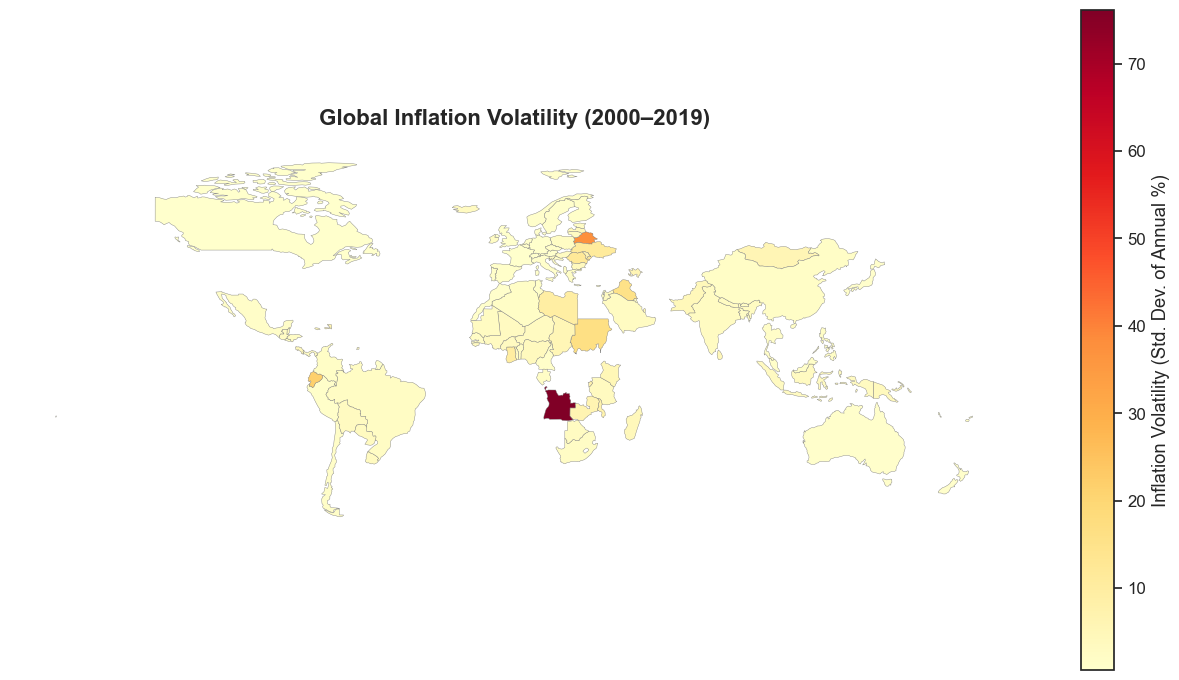

In [288]:

# --- 🧭 Prepare Data ---
df_world = df_inflation.copy()

# --- 🕐 Filter the time period (2000–2019) ---
df_world = df_world[(df_world["year"] >= 2000) & (df_world["year"] <= 2019)]

# --- 📊 Compute standard deviation (volatility) of inflation per country ---
volatility_global = (
    df_world.groupby("country")["inflation_annual%"]
    .std()
    .reset_index()
    .rename(columns={"inflation_annual%": "inflation_volatility"})
)

# --- 🌎 Load world shapefile (modern version for GeoPandas ≥ 1.0) ---
world = gpd.read_file(
    "https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_110m_admin_0_countries.geojson"
)

# --- 🔗 Merge shapefile with volatility data ---
world_vol = world.merge(volatility_global, left_on="NAME", right_on="country", how="left")

# --- 🎨 Plot ---
sns.set(style="white", font_scale=1.1)
fig, ax = plt.subplots(figsize=(13, 7))

# Plot global volatility map
world_vol.plot(
    column="inflation_volatility",
    cmap="YlOrRd",
    linewidth=0.3,
    edgecolor="gray",
    legend=True,
    legend_kwds={
        "label": "Inflation Volatility (Std. Dev. of Annual %)",
        "orientation": "vertical"
    },
    ax=ax
)

# Titles and styling
ax.set_title(
    "Global Inflation Volatility (2000–2019)",
    fontsize=16,
    weight="bold",
    pad=15
)
ax.axis("off")
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


/var/folders/64/4f9k2wyx0r14830_8g7xntcw0000gn/T/ipykernel_89785/2248542796.py:48: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  .apply(lambda g: g.unary_union.centroid)


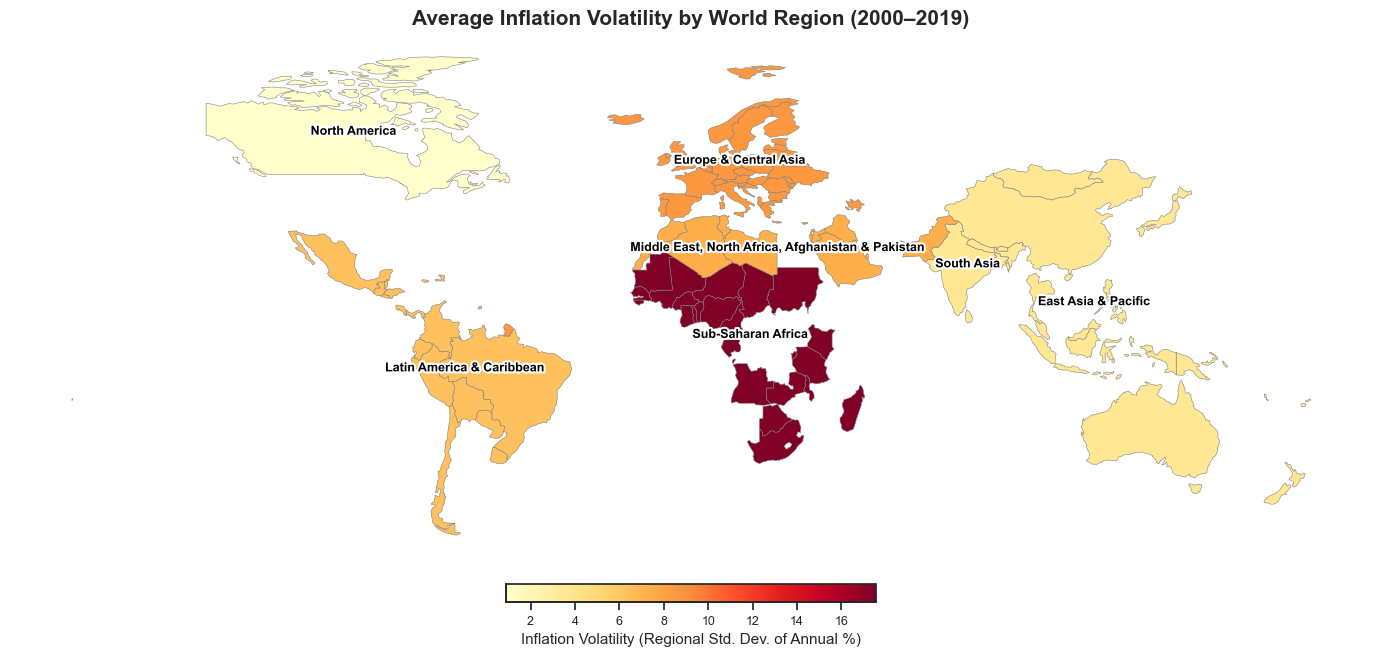

In [302]:

# --- Step 1: Compute std for each region ---
region_std = (
    df_inflation[df_inflation["year"].between(2000, 2019)]
    .groupby("Region")["inflation_annual%"]
    .std()
    .reset_index()
    .rename(columns={"inflation_annual%": "inflation_std"})
)

# --- Step 2: Merge std back into GeoDataFrame ---
world = gpd.read_file(
    "https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_110m_admin_0_countries.geojson"
)
country_region = df_inflation[["country", "Region"]].drop_duplicates()
world = world.merge(country_region, left_on="NAME", right_on="country", how="left")
world = world.merge(region_std, on="Region", how="left")

# --- Step 3: Plot ---
sns.set(style="white", font_scale=1.05)
fig, ax = plt.subplots(figsize=(14, 7))

cmap = "YlOrRd"
vmin, vmax = world["inflation_std"].min(), world["inflation_std"].max()
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

# World colored by regional inflation volatility
world.plot(
    column="inflation_std",
    cmap=cmap,
    linewidth=0.4,
    edgecolor="gray",
    legend=False,
    norm=norm,
    ax=ax
)

# --- Step 4: Add region labels ---
region_labels = (
    world.groupby("Region")["geometry"]
    .apply(lambda g: g.unary_union.centroid)
    .reset_index()
)

for _, row in region_labels.iterrows():
    ax.text(
        row.geometry.x,
        row.geometry.y,
        row.Region,
        fontsize=9,
        ha="center",
        va="center",
        color="black",
        weight="bold",
        path_effects=[patheffects.withStroke(linewidth=3, foreground="white")]  # ✅ now works
    )

# --- Step 5: Add colorbar ---
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cb = plt.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.03, pad=0.04)
cb.set_label("Inflation Volatility (Regional Std. Dev. of Annual %)", fontsize=11)
cb.ax.tick_params(labelsize=9)

# --- Titles and cleanup ---
ax.set_title("Average Inflation Volatility by World Region (2000–2019)", fontsize=15, weight="bold")
ax.axis("off")
sns.despine()
plt.tight_layout()
plt.show()


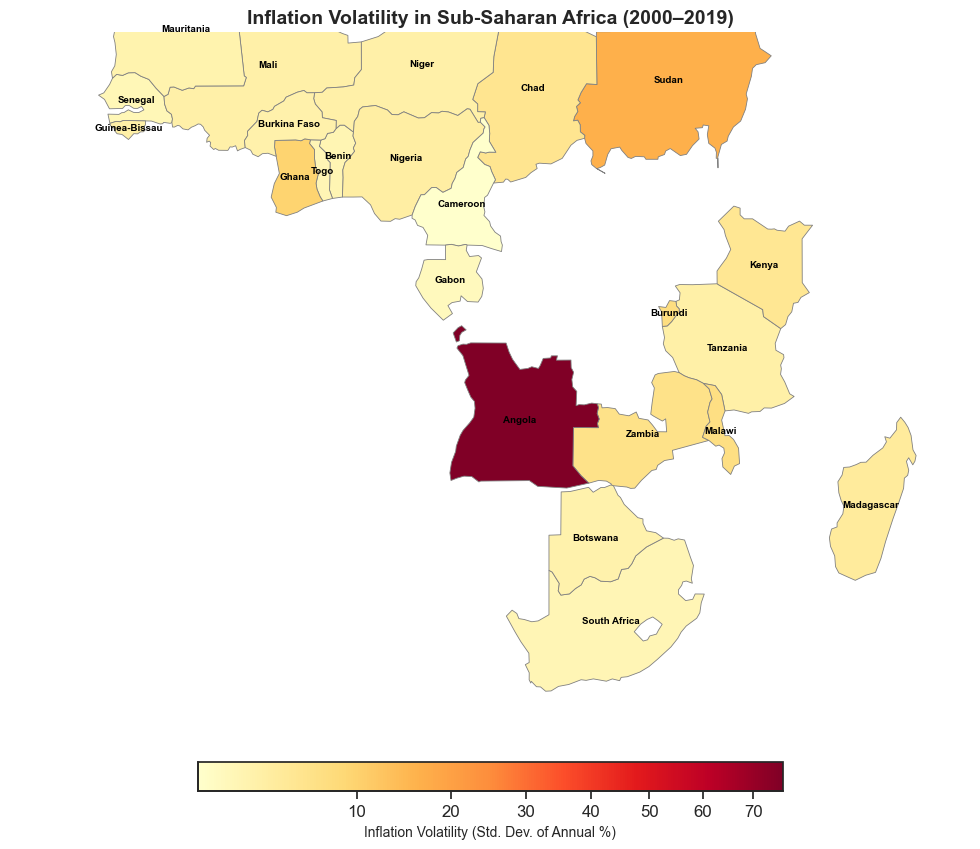

In [304]:


fig, ax = plt.subplots(figsize=(10, 9))
cmap = "YlOrRd"

# 💡 Instead of linear normalization, use PowerNorm to emphasize lower values
vmin, vmax = ssa["inflation_std"].min(), ssa["inflation_std"].max()
norm = mcolors.PowerNorm(gamma=0.6, vmin=vmin, vmax=vmax)  
# smaller gamma (<1) → more intense reds even for moderate values

ssa.plot(
    column="inflation_std",
    cmap=cmap,
    linewidth=0.6,
    edgecolor="gray",
    legend=False,
    norm=norm,
    ax=ax
)

# Country labels (optional)
for idx, row in ssa.iterrows():
    centroid = row["geometry"].centroid
    ax.text(
        centroid.x,
        centroid.y,
        row["country"],
        fontsize=7,
        ha="center",
        va="center",
        color="black",
        weight="bold"
    )

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cb = plt.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.036, pad=0.04)
cb.set_label("Inflation Volatility (Std. Dev. of Annual %)", fontsize=10)

# Zoom and title
ax.set_xlim(-25, 55)
ax.set_ylim(-38, 20)
ax.set_title(
    "Inflation Volatility in Sub-Saharan Africa (2000–2019)",
    fontsize=14,
    weight="bold"
)
ax.axis("off")
sns.despine()
plt.tight_layout()
plt.show()


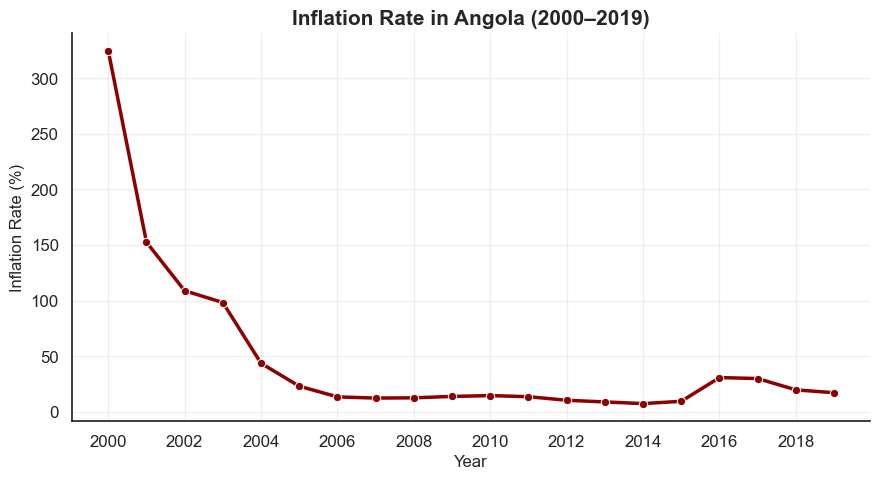

In [311]:

# --- Filter Angola data ---
angola = df_inflation[df_inflation["country"] == "Angola"].copy()

# --- Plot ---
plt.figure(figsize=(9,5))
sns.lineplot(
    data=angola,
    x="year",
    y="inflation_annual%",
    color="darkred",
    marker="o",
    linewidth=2.5
)

# --- X-axis ticks every 2 years ---
plt.xticks(np.arange(int(angola["year"].min()), int(angola["year"].max())+1, 2))

# --- Styling ---
plt.title("Inflation Rate in Angola (2000–2019)", fontsize=15, weight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Inflation Rate (%)", fontsize=12)
plt.grid(alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()


#### Environmental Sustainability: CO₂ Emissions

**Research Question:** Do different income groups differ in CO₂ emissions?

Initial Inspections - Plots (Histogram for Numeric Example: GDP)

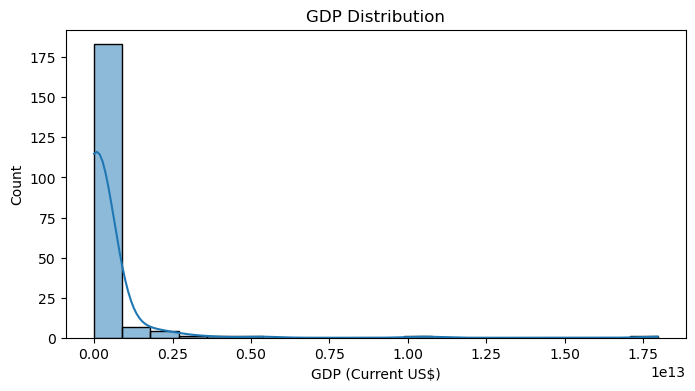

In [27]:
plt.figure(figsize=(8,4))
sns.histplot(df_avg['GDP_current_US'].dropna(), bins=20, kde=True)
plt.title('GDP Distribution')
plt.xlabel('GDP (Current US$)')
plt.ylabel('Count')
plt.show()

Initial Inspections - Plots (Barplot for Categorical Example: Income Group)

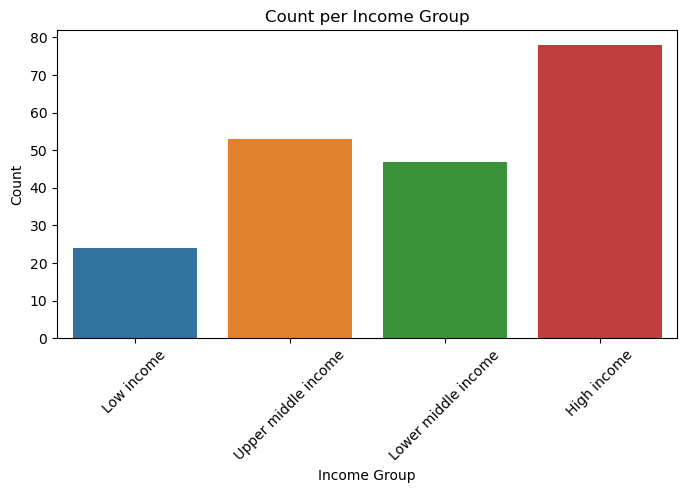

In [29]:
plt.figure(figsize=(8,4))
sns.countplot(x='Income_group', data=df_avg)
plt.title('Count per Income Group')
plt.xlabel('Income Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

ANOVA - Prepare Data for CO2 Emissions

In [31]:
# Research question: Do income groups differ in CO2 emissions?
var = 'CO2_emissions'
group_col = 'Income_group'

data = df_avg[[var, group_col]].dropna()
print("Data for ANOVA shape:", data.shape)

Data for ANOVA shape: (182, 2)


ANOVA - Boxplot

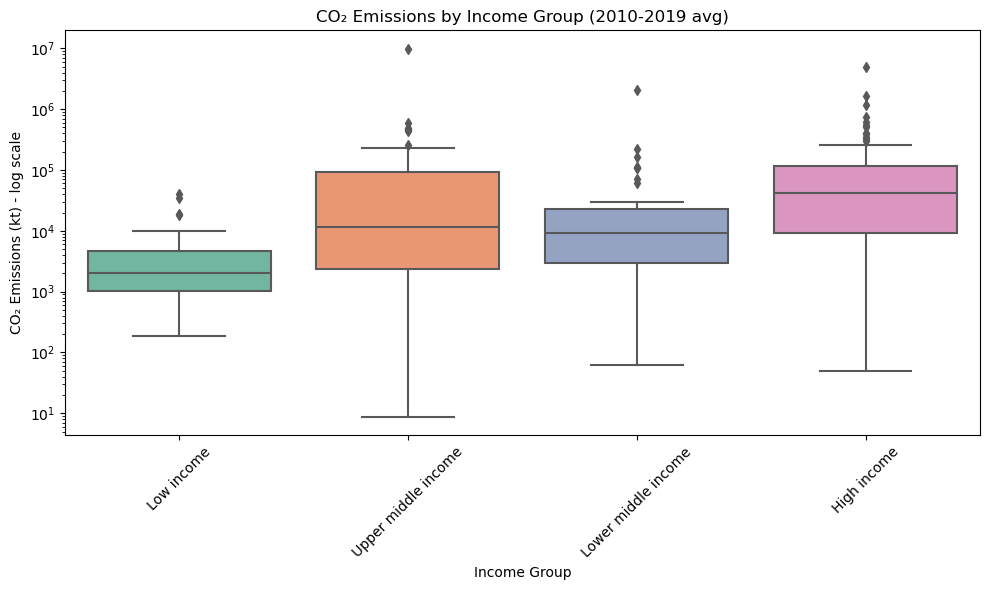

In [32]:
plt.figure(figsize=(10,6))
sns.boxplot(x=group_col, y=var, data=data, palette='Set2')
plt.yscale('log')
plt.title('CO₂ Emissions by Income Group (2010-2019 avg)')
plt.ylabel('CO₂ Emissions (kt) - log scale')
plt.xlabel('Income Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

ANOVA - Assumptions Check

In [34]:
from scipy import stats
# Group sizes
sizes = data[group_col].value_counts()
print("\nGroup sizes:", sizes)

# Levene (equal variance)
groups = [data[data[group_col]==g][var].values for g in data[group_col].unique()]
levene = stats.levene(*groups)
print(f"\nLevene p = {levene.pvalue:.2e} → equal variance: {levene.pvalue > 0.05}")

# Normality (Shapiro per group)
shapiro_p = [stats.shapiro(g)[1] for g in groups]
print("\nShapiro p per group:", shapiro_p)


Group sizes: High income            60
Upper middle income    52
Lower middle income    46
Low income             24
Name: Income_group, dtype: int64

Levene p = 4.66e-01 → equal variance: True

Shapiro p per group: [8.363138022104977e-07, 1.7775791079431384e-15, 2.6114805034161553e-14, 5.54131961060726e-15]


ANOVA - Log Transform

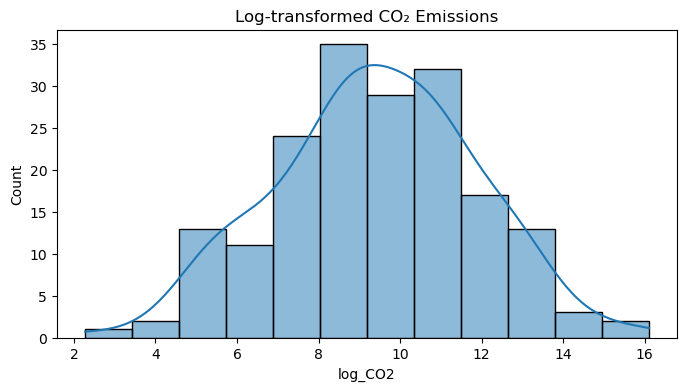

In [35]:
data['log_CO2'] = np.log(data[var] + 1)
var_log = 'log_CO2'

# Re-check normality (visual)
plt.figure(figsize=(8,4))
sns.histplot(data[var_log], kde=True)
plt.title('Log-transformed CO₂ Emissions')
plt.show()

ANOVA - Run ANOVA

In [38]:
# --- 19. ANOVA - Run ANOVA (FIXED) ---
data['log_CO2'] = np.log(data['CO2_emissions'] + 1)

# WAY 2: Use Q() for spaces
formula = 'log_CO2 ~ C(Q("Income_group"))'

model = ols(formula, data=data).fit()
anova_table = anova_lm(model, typ=3)

print("\nANOVA Table:")
print(anova_table)

p_anova = anova_table.loc['C(Q("Income_group"))', 'PR(>F)']
print(f"\nANOVA p-value: {p_anova:.2e}")


ANOVA Table:
                           sum_sq     df            F        PR(>F)
Intercept             6480.220473    1.0  1202.403004  4.291381e-81
C(Q("Income_group"))   132.630762    3.0     8.203200  3.822462e-05
Residual               959.311679  178.0          NaN           NaN

ANOVA p-value: 3.82e-05


ANOVA - Residuals Check

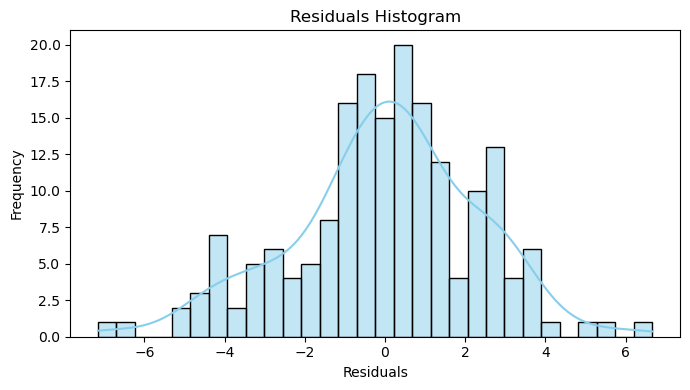

Residuals Shapiro p-value: 8.05e-02
If p > 0.05 → residuals approximately normal


In [39]:
residuals = model.resid

plt.figure(figsize=(7, 4))
sns.histplot(residuals, bins=30, kde=True, color='skyblue')
plt.title('Residuals Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

shapiro_res = stats.shapiro(residuals)[1]
print(f"Residuals Shapiro p-value: {shapiro_res:.2e}")
print("If p > 0.05 → residuals approximately normal")

ANOVA - Explained Variance

In [40]:
ss_model = anova_table['sum_sq'][1]
ss_residual = anova_table['sum_sq'][2]
ss_total = ss_model + ss_residual
explained_variance = ss_model / ss_total
print(f"Explained variance: {explained_variance:.3f}")

Explained variance: 0.121


ANOVA - Post-hoc Tukey

In [42]:
# --- 22. Post-hoc Tukey ---
if p_anova < 0.05:
    tukey = pairwise_tukeyhsd(endog=data['log_CO2'], groups=data['Income_group'], alpha=0.05)
    print("\nTukey HSD:")
    print(tukey)
else:
    print("No significant difference")


Tukey HSD:
             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
       group1              group2       meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------
        High income          Low income  -2.6153    0.0 -4.0695 -1.1612   True
        High income Lower middle income  -1.4647 0.0082 -2.6446 -0.2847   True
        High income Upper middle income  -0.9562 0.1345 -2.0969  0.1845  False
         Low income Lower middle income   1.1507 0.2039 -0.3654  2.6668  False
         Low income Upper middle income   1.6592 0.0219  0.1734  3.1449   True
Lower middle income Upper middle income   0.5085 0.7009 -0.7102  1.7271  False
------------------------------------------------------------------------------


Save Plot for Report

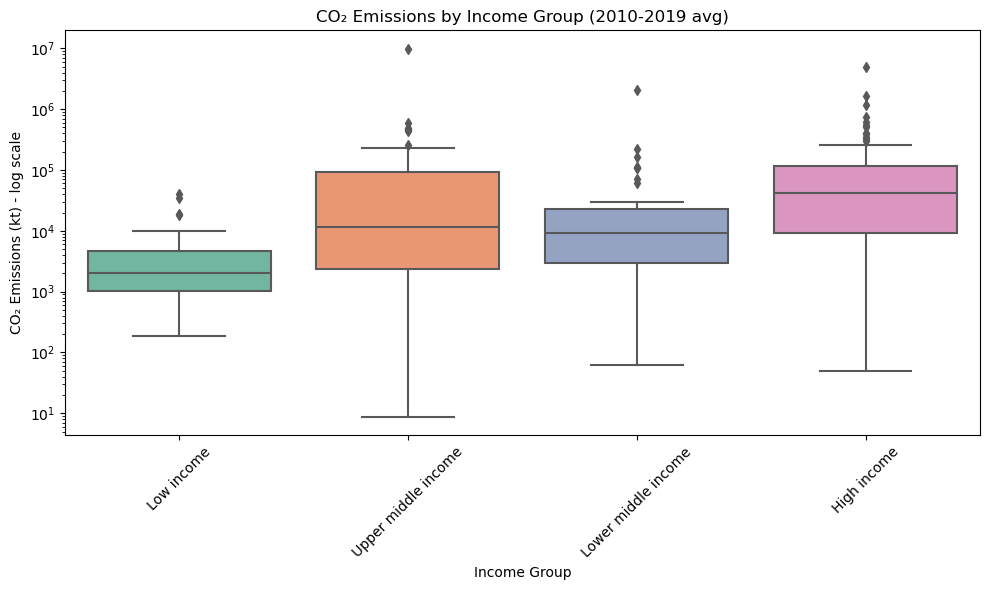

In [44]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Income_group', y='CO2_emissions', data=data, palette='Set2')
plt.yscale('log')
plt.title('CO₂ Emissions by Income Group (2010-2019 avg)')
plt.ylabel('CO₂ Emissions (kt) - log scale')
plt.xlabel('Income Group')
plt.xticks(rotation=45)
plt.tight_layout()